# GooglePlay Apps - Analysis
<img src="https://larepublica.pe/resizer/tfFsh8GirRCY-F-k78brpY-cNCU=/1250x735/top/smart/cloudfront-us-east-1.images.arcpublishing.com/gruporepublica/NY2YWUWXD5A7ZO75YOEQ5UTULQ.png" 
alt="GooglePlay" 
style="width: 800px; margin-left: 50; margin-right: 50;"/>


As of May 2022, there are *more than 3.3 million Android apps on GooglePlay store*.  Contrast this with iOS, which has 2.2 million apps on the App Store.
There are *2.2 billion android users* worldwide and commands *72% Mobile OS marketshare!* Currently, about *4000 new apps are getting added to GooglePlay store every day*, and the numbers are still moving north!

So let's explore the Apps and Games in GooglePlay store and anazlye the chracterstics of the most popular ones in the list.

> **Problem Definition - As the GooglePlay store is crowded with so many Apps and Games, can we study the underlying trends and surcafe out some winning characteristics that makes them successful?**



Import Python libraries

In [ ]:
import pandas as pd
import numpy as np

# regular expressions, for data clean-ups
import re

# plots 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# for wordcloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS

Library to read data from Kaggle

In [ ]:
%pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
gp_app_dataset_url = 'https://www.kaggle.com/datasets/tungmphung/new-google-play-store-android-apps-dataset'
od.download(gp_app_dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: arin102786
Your Kaggle Key: ··········


100%|██████████| 77.5M/77.5M [00:00<00:00, 90.6MB/s]


To visually check the mising values 

In [ ]:
%pip install missingno --upgrade --quiet

In [ ]:
import missingno as msno

## Step 1: Select dataset: Android Apps from GooglePlay Store and User Reviews

This dataset is obtained from scraping Google Play Store in April 2020.

Source: https://www.kaggle.com/datasets/tungmphung/new-google-play-store-android-apps-dataset

#### Contents: 
2 csv files:
1. app.csv with 53,732 rows and 18 columns.
2. comment.csv with 1,468,173 rows and 4 columns.


#### App: Column description
- id: a unique identifier for each app.
- app_name.
- genre (a.k.a category).
- rating.
- reviews: the number of reviews.
- cost_label: If the app is free, the cost_label value is ‘Install‘. If the app is premium, the cost_label value is the price, e.g. ‘đ23,000 Buy‘, ‘đ69,000 Buy‘. 
    - Note - that the currency is in Vietnam dong. At the current time, đ23,000 \approx 1$.
- rate_5_pc, …, rate_1_pc: the percentage of user ratings that vote 5-stars, …, 1-star.
- updated: The date that the app was last updated on the Play Store.
- size: app size.
- installs: the number of installs (or downloads).
- current_version: the current version of the app.
- requires_android: the Android version required for the app to run.
- content_rating: age restriction.
- in_app_products: cost of items in the app.
- offered_by: the developer or team that designed the app.


#### Comment: Column description

- app_id: the id of the app the comment belongs to.
- content: comment’s content, might be truncated if too long.
    - Note that not all comments are recorded. Comments are sorted by relevance and at most 40 most relevant comments are recorded for each app.
- stars: the user rating that is attached to the comment.
- helpfuls: the number of users who found this comment helpful.

## Step 2: Perform data preparation & cleaning

<img src="https://uweccsdatamining101weka.files.wordpress.com/2018/04/datacartoon.jpg" 
alt="GooglePlay" 
style="Height: 400px; margin-left: 50; margin-right: 50;"/>

<a href="https://uweccsdatamining101weka.files.wordpress.com/2018/04/datacartoon.jpg">Inage Source</a>

### Read the CSV files and convert into dataframe using Pandas

#### Dataset 1: App Details

In [ ]:
%%time
selected_cols = ['id', 'app_name', 'genre', 'rating', 'reviews', 'cost_label',
       'rate_5_pc', 'rate_4_pc', 'rate_3_pc', 'rate_2_pc', 'rate_1_pc',
       'updated', 'size', 'installs',
       'content_rating', 'in_app_products', 'offered_by']

# app_df
app_df = pd.read_csv('new-google-play-store-android-apps-dataset/app.csv', 
                            usecols=selected_cols, 
                            parse_dates=['updated'])

# rename size to size_mb as size is a reserved keyword that causes issues later when you do app_df.size
app_df.rename(columns={"size": "size_mb"}, inplace=True) 
app_df.head(5)                         

CPU times: user 486 ms, sys: 46.1 ms, total: 532 ms
Wall time: 546 ms


id                     app_name   genre  rating           reviews  \
0   2  Sonic the Hedgehog™ Classic     NaN     4.1     193,898 total   
1   3                  Push'em all  Action     3.8     119,679 total   
2   5              Sky Fighters 3D  Action     4.2     196,685 total   
3   6                  Robbery Bob  Action     4.3     984,779 total   
4   7               Shadow Fight 2  Action     4.6  12,861,970 total   

  cost_label  rate_5_pc  rate_4_pc  rate_3_pc  rate_2_pc  rate_1_pc  \
0    Install    68.0272   10.20410    5.44218   3.401360   12.92520   
1    Install    56.1798   12.92130    8.42697   5.056180   17.41570   
2    Install    67.1141   11.40940    7.38255   3.355700   10.73830   
3    Install    74.0741    8.14815    5.18518   2.962960    9.62963   
4    Install    85.4701    5.98291    2.56410   0.854701    5.12821   

     updated size_mb      installs content_rating  \
0 2020-03-24     61M   10,000,000+   Rated for 3+   
1 2020-04-16     41M   10,000,000+   Rated for 3+   
2 2019-05-14     19M   10,000,000+   Rated for 7+   
3 2020-03-25     42M   50,000,000+   Rated for 7+   
4 2020-04-15    142M  100,000,000+  Rated for 12+   

                 in_app_products          offered_by  
0               ₫45,000 per item                SEGA  
1               ₫92,000 per item              VOODOO  
2  ₫42,000 - ₫2,100,000 per item  Doodle Mobile Ltd.  
3    ₫18,000 - ₫192,000 per item      Level Eight AB  
4   ₫6,000 - ₫1,149,999 per item               NEKKI

### Explore the number of rows & columns, ranges of values etc.

In [ ]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53732 entries, 0 to 53731
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               53732 non-null  int64         
 1   app_name         53675 non-null  object        
 2   genre            48654 non-null  object        
 3   rating           47688 non-null  float64       
 4   reviews          47688 non-null  object        
 5   cost_label       53653 non-null  object        
 6   rate_5_pc        47688 non-null  float64       
 7   rate_4_pc        47688 non-null  float64       
 8   rate_3_pc        47688 non-null  float64       
 9   rate_2_pc        47688 non-null  float64       
 10  rate_1_pc        47688 non-null  float64       
 11  updated          53675 non-null  datetime64[ns]
 12  size_mb          53675 non-null  object        
 13  installs         53658 non-null  object        
 14  content_rating   53675 non-null  objec

In [ ]:
app_df.describe().T

count          mean           std  min           25%  \
id         53732.0  26870.528289  15516.735617  1.0  13433.750000   
rating     47688.0      4.228942      0.477196  1.0      4.000000   
rate_5_pc  47688.0     68.844503     14.547545  0.0     61.349700   
rate_4_pc  47688.0     11.903311      6.278470  0.0      7.792210   
rate_3_pc  47688.0      5.688799      3.821144  0.0      3.174600   
rate_2_pc  47688.0      2.927431      2.972642  0.0      0.826446   
rate_1_pc  47688.0     10.635961     10.422253  0.0      3.787880   

                   50%          75%         max  
id         26866.50000  40299.25000  53751.0000  
rating         4.30000      4.50000      5.0000  
rate_5_pc     70.42250     78.12500    100.0000  
rate_4_pc     11.47540     15.52800     86.2069  
rate_3_pc      5.34351      7.63889     66.6667  
rate_2_pc      2.25564      3.97351     50.2513  
rate_1_pc      7.80142     14.00000    100.0000

Some of the data that ideally should be nemeric format, like - reviews, size, installs, cost_labels etc, is not listed here.

We will try to convert them into numerics.

### Handle missing, incorrect and invalid data

#### Basic Inspection of Data

In [ ]:
app_df.shape

(53732, 17)

In [ ]:
app_df.isna().sum()

id                     0
app_name              57
genre               5078
rating              6044
reviews             6044
cost_label            79
rate_5_pc           6044
rate_4_pc           6044
rate_3_pc           6044
rate_2_pc           6044
rate_1_pc           6044
updated               57
size_mb               57
installs              74
content_rating        57
in_app_products    29457
offered_by            57
dtype: int64

`app_df` has 53732 rows, and all the coumns have few missing values. 
`in_app_products` has the most missing values.


There are a few missing app_names for which the entire row is missing. Based on their count, we will decide to drop these rows.

In [ ]:
print("Rows without any app name:", app_df.app_name.isna().sum(), "\nDropping them.")

# drop the rows wihtout app names
app_df.dropna(subset=['app_name'], inplace=True)

Rows without any app name: 57 
Dropping them.


Let's have a look again at the missing values. 
After rows with missing values of `app_name` is dropped, we can see there is a concentration of missing value in column `installs`. 
Let's go and check the column.

In [ ]:
app_df.isna().sum()

id                     0
app_name               0
genre               5021
rating              5987
reviews             5987
cost_label            22
rate_5_pc           5987
rate_4_pc           5987
rate_3_pc           5987
rate_2_pc           5987
rate_1_pc           5987
updated                0
size_mb                0
installs              17
content_rating         0
in_app_products    29400
offered_by             0
dtype: int64

In [ ]:
print("Number of missing install values: ", len(app_df[app_df.installs.isna()]), "\nDropping them.")
# before deciding to drop these rows, let's check the content 
# app_df[app_df.installs.isna()].sample(5)
# as most of the oterh columns are null too, let's drop these rows 
app_df.dropna(subset=['installs'], inplace=True)

Number of missing install values:  17 
Dropping them.


Finally, let's do a visual inspection of the missing data to understand if we have to handle more missing value cases or not.

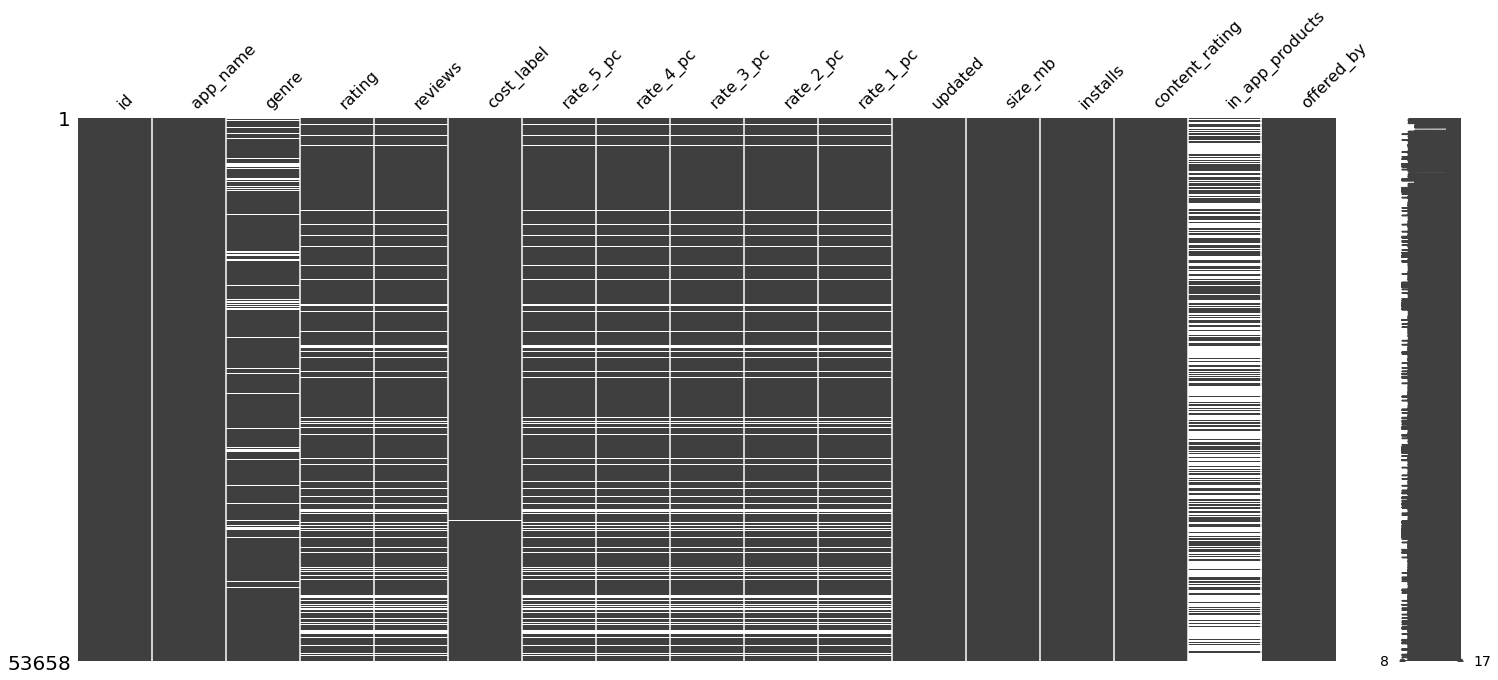

In [ ]:
msno.matrix(app_df);

Now we can see there are no any small isolated cases of missing values in the dataset apart from `cost_label`. We will revist this later while cleaning up the data further.

Column `in_app_product` has a maximum number of missing values. We will later inspect if there is any parrern to it. Based on the findings, we may or may not use them for further analysis.

### Data wrangling

> Definition: Data wrangling, sometimes referred to as data munging, is the process of transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as analytics. 

We will now inspect the data, column by column, to validate, clean, re-structure, and make it condusive for exploration, analysis, plotting and inference.

In [ ]:
# read a random sample of the data
app_df.sample(3)

id                                           app_name         genre  \
41070  42477  Sad wallpaper: Unhappy quote, anime sad wallpaper     Lifestyle   
38365  39582                             Ritual: Sorcerer Angel  Role Playing   
51950  52622                          TriPeaks Cowboy Solitaire          Card   

       rating      reviews cost_label  rate_5_pc  rate_4_pc  rate_3_pc  \
41070     4.4  5,092 total    Install    72.9927   12.40880    6.56934   
38365     3.9    860 total    Install    50.7614   22.84260    7.61421   
51950     4.7  1,966 total    Install    87.7193    6.14035    1.75439   

       rate_2_pc  rate_1_pc    updated size_mb  installs content_rating  \
41070    2.18978    5.83942 2020-04-20    4.8M  100,000+  Rated for 12+   
38365    8.62944   10.15230 2019-10-18     25M   50,000+   Rated for 7+   
51950    0.00000    4.38596 2020-04-21     25M   50,000+   Rated for 3+   

                     in_app_products          offered_by  
41070                            NaN  Do the right thing  
38365    ₫99,000 - ₫199,000 per item              HEXAGE  
51950  ₫22,000 - ₫2,250,000 per item     mahjong connect

### `genere` column

1. Uptate the `genere` column with values 'App' and 'Game' 
    - If the genre contains Action, adventure, Arcade, Board, Card, Casino, Casual, Educational, Music, Puzzle, Racing, Role Playing, Simulation, Sports, Strategy, Trivia, Word, then replace it with 'Game'.
    - If not, replace it with 'App'.
    - If `genre` is missing, and if the data is siazable, come up with a guestimate strategy.
2. Create two new columns called `app_generes` and `game_genere` with old content from `genere` column, if it matches values from the list.

Let's begin with inspecting the rows where genere values is missing. If there are very few, we can drop the rows. If not, we have to come up coupe wup with a rule to fill them reasonably.

In [ ]:
print("Number of rows with missing 'genre' are:", len(app_df[app_df.genre.isna()]))
app_df[app_df.genre.isna()].sample(3)

Number of rows with missing 'genre' are: 5020


id                                           app_name genre  rating  \
25086  25485  Bedtime Story: Audio Books & fairy tales for Kids   NaN     4.2   
13801  14602                    Sweet Panda Pet Daycare Nursery   NaN     4.1   
24697  25073                                        CHESSMASTER   NaN     4.7   

         reviews   cost_label  rate_5_pc  rate_4_pc  rate_3_pc  rate_2_pc  \
25086    9 total      Install    78.1250    0.00000    0.00000  10.937500   
13801   78 total      Install    70.4225    4.92958    9.85915   0.704225   
24697  204 total  ₫22,000 Buy    85.4701    9.40171    1.70940   1.709400   

       rate_1_pc    updated size_mb  installs content_rating  \
25086    10.9375 2020-04-24    9.7M    1,000+   Rated for 3+   
13801    14.0845 2019-08-23     39M  100,000+   Rated for 3+   
24697     1.7094 2019-10-23     40M    1,000+   Rated for 3+   

                   in_app_products                       offered_by  
25086  ₫23,000 - ₫220,000 per item  Test speed internet & Net meter  
13801   ₫23,000 - ₫69,000 per item                    Burbuja Games  
24697                          NaN                      Alexey Gara

As from the app names we can reasonably guess that the missing genre are actually games, let's fill them as 'Game`. 

Next, update the `genre` with values 'App' or 'Game' based on their current 'genre'. We will create 2 new columns with for this.

In [ ]:
# Check the app genre - if it is a game or a non-game app 
# -------------------------------------------------------------
# As we found the missing values are games, adding NaN is the list to make the NaNs as games 
game_genere_list = ['Action', 'Adventure', 'Arcade', 'Board', 'Card', 'Casino', 'Casual', 'Educational', 'Music', 'Puzzle', 'Racing', 'Role Playing', 'Simulation', 'Sports', 'Strategy', 'Trivia', 'Word', np.NaN]

# -------------------------------------------------------------
# create 2 new new columns - game_genre and app_genre
app_df['game_genre'] = np.where(app_df.genre.isin(game_genere_list), app_df.genre, np.NaN)
app_df['app_genre'] = np.where(~app_df.genre.isin(game_genere_list), app_df.genre, np.NaN)

# rename the column name from genre to app_category
app_df.rename(columns={"genre": "app_category"}, inplace=True)

# update the contents of renamed category column (old name genre) based on it it was a game or a non-game app
app_df['app_category'] = np.where(app_df.app_category.isin(game_genere_list), "Game", "App")

# -------------------------------------------------------------
# replace nan with blank string for concatnation
app_df["game_genre"] = app_df["game_genre"].astype(str).replace("nan", "")
app_df["app_genre"] = app_df["app_genre"].astype(str).replace("nan", "")
# for data viz and agrregation, we want to create a new column called 'genre' with merged contents of 'app_genre' and 'app_genre' in single column
app_df["genre"] = app_df["app_genre"] + app_df["game_genre"]


# -------------------------------------------------------------
# make the blank space "" to NaN for aggregating and plottng later
app_df["genre"] = app_df["genre"].replace("", np.nan)
app_df["game_genre"] = app_df["game_genre"].replace("", np.nan)
app_df["app_genre"] = app_df["app_genre"].replace("", np.nan)

# -------------------------------------------------------------
# change to categorical datatype
app_df['app_category'] = app_df['app_category'].astype("category")
app_df['game_genre'] = app_df['game_genre'].astype("category")
app_df['app_genre'] = app_df['app_genre'].astype("category")
app_df['genre'] = app_df['genre'].astype("category")

app_df.sample(3)

id                                  app_name app_category  rating  \
42909  44423                     3D Next Tech Keyboard          App     4.5   
28162  28768                              MarilynMania         Game     4.5   
4126    4410  Free Books : SSC,UPSC,Railway,Bank,NCERT          App     4.2   

            reviews cost_label  rate_5_pc  rate_4_pc  rate_3_pc  rate_2_pc  \
42909  18,938 total    Install    76.3359   11.45040    4.58015    1.52672   
28162   1,544 total    Install    78.7402    8.66142    5.51181    2.36220   
4126       13 total    Install    62.1118   15.52800    7.45342    7.45342   

       rate_1_pc    updated size_mb    installs content_rating  \
42909    6.10687 2018-06-26    5.6M  1,000,000+   Rated for 3+   
28162    4.72441 2017-05-28     61M     10,000+   Rated for 3+   
4126     7.45342 2020-03-12    8.9M        100+   Rated for 3+   

        in_app_products                  offered_by game_genre  \
42909               NaN  Emoji Cute Keyboard Themes        NaN   
28162  ₫39,000 per item          Unlikely Games Kft   Strategy   
4126                NaN              Mukesh Kaushik        NaN   

               app_genre              genre  
42909    Personalization    Personalization  
28162                NaN           Strategy  
4126   Books & Reference  Books & Reference

#### `reviews` column
- drop the character ' , ' and text 'total'
- convert to float datatype

In [ ]:
# Drop 'total' and ',' from review column and convert it into numeric value
app_df.reviews = app_df.reviews.str.replace('total', ' ').str.replace(',', '').astype(float)
app_df.head(3)

id                     app_name app_category  rating   reviews cost_label  \
0   2  Sonic the Hedgehog™ Classic         Game     4.1  193898.0    Install   
1   3                  Push'em all         Game     3.8  119679.0    Install   
2   5              Sky Fighters 3D         Game     4.2  196685.0    Install   

   rate_5_pc  rate_4_pc  rate_3_pc  rate_2_pc  rate_1_pc    updated size_mb  \
0    68.0272    10.2041    5.44218    3.40136    12.9252 2020-03-24     61M   
1    56.1798    12.9213    8.42697    5.05618    17.4157 2020-04-16     41M   
2    67.1141    11.4094    7.38255    3.35570    10.7383 2019-05-14     19M   

      installs content_rating                in_app_products  \
0  10,000,000+   Rated for 3+               ₫45,000 per item   
1  10,000,000+   Rated for 3+               ₫92,000 per item   
2  10,000,000+   Rated for 7+  ₫42,000 - ₫2,100,000 per item   

           offered_by game_genre app_genre   genre  
0                SEGA        NaN       NaN     NaN  
1              VOODOO     Action       NaN  Action  
2  Doodle Mobile Ltd.     Action       NaN  Action

#### `cost_label` column
- Text 'install' denotes a free app. We change it to 0.
- For paid app, if the value is string like '₫69,000 Buy', retain only the number portion and drop the Vietnam dong symbol and 'Buy' text 
- Some has text like 'Was ₫10900000 now reduced to ₫530000'. We retain the old price and discard the remaining part. 
- There are a few apps without 'cost_label'. We will drop them
- For paid apps, convert the Vietnam dong value into USD (đ23,000 = $1)
- Finally make the column values as numeric

In [ ]:
print("Number of rows with undefined cost_label: ", app_df['cost_label'].isna().sum())

# -------------------------------------------------------------
# Drop the rows wihtout cost_label
app_df.dropna(subset=['cost_label'], inplace=True)

# -------------------------------------------------------------
# Replace 'Install' with 0, remove commas, drop currency symbol, and drop the string 'Buy'
app_df.cost_label = app_df.cost_label.str.replace('Install', '0').str.replace(',', '').str.replace('₫', '').str.replace(' Buy', '')

# -------------------------------------------------------------
# there are few entires like 'Was 182000 now reduced to 101000'
#  in such cases, we have to extract the reduced price from string
def get_new_cost(row):
  if 'Was' in str(row['cost_label']):
    x = re.findall(r'\d+',row['cost_label'])[0]
  else:
    x = row['cost_label']
  return x

# after replacing the string with the reduced cost, convert it to float and handle the null values
app_df.cost_label = app_df.apply(lambda row: get_new_cost(row), axis = 1)
app_df.cost_label = app_df.cost_label.astype(float).fillna(np.NaN)

# -------------------------------------------------------------
# Convert Vietnam dong to usd 
app_df.cost_label = app_df.cost_label.apply(lambda x: round(x/23000,1))

# -------------------------------------------------------------
# create a new column 'app_type'. If cost_label is 'Install', make it as 'Free' Else 'Paid'
def find_app_type(row):
    """Find App Type - Free or Paid.""" 
    if row['cost_label'] == 0:
        return 'Free'
    else:
        return 'Paid'

app_df['app_type'] = app_df.apply(lambda row: find_app_type(row), axis = 1)

# -------------------------------------------------------------
app_df.sample(3)

Number of rows with undefined cost_label:  5


id                                           app_name app_category  \
36583  37694                            Affirmations for Wealth          App   
45732  47414  Freetour.com - travel app for budget & free tours          App   
51299  51932                                Scales Practice Pro          App   

       rating  reviews  cost_label  rate_5_pc  rate_4_pc  rate_3_pc  \
36583     4.6    186.0         0.0    79.3651    12.6984    4.76190   
45732     4.4    425.0         0.0    75.7576    10.6061    4.54545   
51299     4.5    212.0         2.1    70.4225    21.1268    2.81690   

       rate_2_pc  ...    updated size_mb  installs content_rating  \
36583    1.58730  ... 2017-02-19    1.3M    5,000+   Rated for 3+   
45732    1.51515  ... 2020-04-15     11M  100,000+   Rated for 3+   
51299    1.40845  ... 2019-08-31    3.4M    1,000+   Rated for 3+   

         in_app_products     offered_by game_genre       app_genre  \
36583  ₫125,000 per item  Balance In Me        NaN    Productivity   
45732                NaN   Viagio Group        NaN  Travel & Local   
51299                NaN      Stonekick        NaN   Music & Audio   

                genre app_type  
36583    Productivity     Free  
45732  Travel & Local     Free  
51299   Music & Audio     Paid  

[3 rows x 21 columns]

#### `size_mb` column
- Drop the `M` and retain the number part
- There are some app sized less than 1 MB. These are in KBs and contains text 'k'. We can approximate them as 1 MB for convinience. 
- There are a few entires with 'Varies with device'. These are not helpful for analysis. We will set them to -1.
- Convert this column to numeric

In [ ]:
# drop the 'M' from size figure
app_df['size_mb'] = app_df.size_mb.str.replace('M', '')

# replace values with k with 1 (we will make all sizes in KBs as 1 MB)
app_df['size_mb'] = app_df['size_mb'].mask(app_df['size_mb'].str.contains('k')==True, 1)

# replace the 'Varies with device' with a numerical value -1
app_df['size_mb'] = app_df['size_mb'].mask(app_df['size_mb'].isin(['Varies with device']), -1)

# Finally converted into float 
app_df.size_mb = app_df.size_mb.astype(float)
app_df.head(3)

id                     app_name app_category  rating   reviews  cost_label  \
0   2  Sonic the Hedgehog™ Classic         Game     4.1  193898.0         0.0   
1   3                  Push'em all         Game     3.8  119679.0         0.0   
2   5              Sky Fighters 3D         Game     4.2  196685.0         0.0   

   rate_5_pc  rate_4_pc  rate_3_pc  rate_2_pc  ...    updated size_mb  \
0    68.0272    10.2041    5.44218    3.40136  ... 2020-03-24    61.0   
1    56.1798    12.9213    8.42697    5.05618  ... 2020-04-16    41.0   
2    67.1141    11.4094    7.38255    3.35570  ... 2019-05-14    19.0   

      installs content_rating                in_app_products  \
0  10,000,000+   Rated for 3+               ₫45,000 per item   
1  10,000,000+   Rated for 3+               ₫92,000 per item   
2  10,000,000+   Rated for 7+  ₫42,000 - ₫2,100,000 per item   

           offered_by game_genre app_genre   genre app_type  
0                SEGA        NaN       NaN     NaN     Free  
1              VOODOO     Action       NaN  Action     Free  
2  Doodle Mobile Ltd.     Action       NaN  Action     Free  

[3 rows x 21 columns]

#### `installs` column
- Remove the special characters '+' and ','
- There many appis with inssignificant nuber of installs. We can round them off to 500 if the installs is less than 1000.
- Convert the installs into numeric column
- Create a new column `install_range` as an ordered categorical datatype. This will come handy for later analysis and plotting.

In [ ]:
# Get rid of '+' and ',' from installs and convert it to float
app_df.installs = app_df.installs.str.replace('+', '', regex=True).str.replace(',', '',regex=True).astype(float)

# -------------------------------------------------------------
# If the install numnber is more than 1000, retain the existing value. If not, round it off to 500
app_df['installs'].where(app_df['installs'] >= 1000, 500, inplace=True)

# -------------------------------------------------------------
# Create a new column for number of installs as a category. This is becasue, in the original dataset, installs are in value range, not as numbers
install_dict = {5.000000e+02: "500+", 1.000000e+03: "1K+", 5.000000e+03:"5K+", 1.000000e+04: "10K+", 5.000000e+04: "50K+", 1.000000e+05: "100K+", 5.000000e+05: "500K+",
               1.000000e+06: "1M+", 5.000000e+06: "5M+", 1.000000e+07:"10M+", 5.000000e+07: "50M+", 1.000000e+08:"100M+", 5.000000e+08:"500M+",
               1.000000e+09:"1B+", 5.000000e+09:"5B+"}

# create a new coulmn 'install_range with the installs of the app as a categorical datatype
app_df['installs_range'] = app_df['installs'].map(install_dict)

# we want to keep the install count in order 
install_range_order = ["500+", "1K+", "5K+", "10K+", "50K+", "100K+", "500K+", "1M+", "5M+", "10M+", "50M+", "100M+", "500M+", "1B+", "5B+"]
app_df['installs_range'] = pd.Categorical(app_df['installs_range'], categories = install_range_order)

# -------------------------------------------------------------
# check the new dataframe
app_df.sort_values(by = "installs_range").sample(3)

id                                           app_name app_category  \
13669  14464                         Miga Town: My Fire Station         Game   
11786  12468                                       Kumeyl Duası          App   
4675    4933  FunnyFood Christmas Games for Toddlers 3 years ol         Game   

       rating  reviews  cost_label  rate_5_pc  rate_4_pc  rate_3_pc  \
13669     3.6   6102.0         0.0    52.6316    8.94737    8.94737   
11786     NaN      NaN         0.0        NaN        NaN        NaN   
4675      4.2    348.0         0.0    69.9301   11.88810    1.39860   

       rate_2_pc  ...  size_mb   installs  content_rating   in_app_products  \
13669    5.78947  ...     38.0  1000000.0    Rated for 3+  ₫93,000 per item   
11786        NaN  ...     16.0     5000.0    Rated for 3+               NaN   
4675     4.89510  ...     31.0   100000.0    Rated for 3+  ₫20,000 per item   

                                          offered_by game_genre  app_genre  \
13669  XiHe Digital (GuangZhou) Technology Co., Ltd.        NaN        NaN   
11786                                        MiracTV        NaN  Education   
4675                           MAGE Studio Kid Games        NaN        NaN   

           genre app_type installs_range  
13669        NaN     Free            1M+  
11786  Education     Free            5K+  
4675         NaN     Free          100K+  

[3 rows x 22 columns]

#### `content_rating` column
- Convert to ordered categorical datatype

In [ ]:
content_rating_order = ["Rated for 3+", "Rated for 7+", "Rated for 12+", "Rated for 16+", "Rated for 18+", "Unrated"]

app_df['content_rating'] = pd.Categorical(app_df['content_rating'], categories = content_rating_order)

#### `in_app_products` column
- Remove currency symbol, ' , ', and other strings
- Extract the numbers - minimum and maximum prices, and retain the minimum. It's a fair estimate of the price and will suffice for our anlysis
- Convert datatype into float
- Convert the currency value from Vietnam Dong to USD

In [ ]:
# clean up the string and retain numbers 
app_df.in_app_products = app_df.in_app_products.str.replace(',', '').str.replace('-', '').str.replace('₫', '').str.replace('per item', '')

# from the numbers, keep the minumum value and convert it into float
app_df.in_app_products = app_df.in_app_products.str.extract(r'(\d+)')[0].astype(float)

# Convert Vietnam dong to usd 
app_df.in_app_products = app_df.in_app_products.apply(lambda x: round(x/23000,1))
app_df.sample(3)

id                      app_name app_category  rating  reviews  \
27950  28543                        WiaTag          App     3.6    113.0   
10126  10715  SWEAT: Kayla Itsines Fitness          App     4.3  24246.0   
50574  51164               Chicken Recipes          App     4.4   5142.0   

       cost_label  rate_5_pc  rate_4_pc  rate_3_pc  rate_2_pc  ...  size_mb  \
27950         0.0    53.1915    9.04255   10.63830   5.319150  ...      5.6   
10126         0.0    74.6269    8.20895    2.23881   0.746269  ...     27.0   
50574         0.0    67.5676   16.21620    8.78378   2.702700  ...      7.4   

        installs  content_rating  in_app_products       offered_by  \
27950    10000.0    Rated for 3+              NaN           GURTAM   
10126  5000000.0    Rated for 3+              0.3            Sweat   
50574   500000.0    Rated for 3+              NaN  Share and Enjoy   

       game_genre          app_genre              genre app_type  \
27950         NaN  Maps & Navigation  Maps & Navigation     Free   
10126         NaN   Health & Fitness   Health & Fitness     Free   
50574         NaN       Food & Drink       Food & Drink     Free   

      installs_range  
27950           10K+  
10126            5M+  
50574          500K+  

[3 rows x 22 columns]

#### Validate clean-up

In [ ]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53653 entries, 0 to 53731
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               53653 non-null  int64         
 1   app_name         53653 non-null  object        
 2   app_category     53653 non-null  category      
 3   rating           47684 non-null  float64       
 4   reviews          47684 non-null  float64       
 5   cost_label       53653 non-null  float64       
 6   rate_5_pc        47684 non-null  float64       
 7   rate_4_pc        47684 non-null  float64       
 8   rate_3_pc        47684 non-null  float64       
 9   rate_2_pc        47684 non-null  float64       
 10  rate_1_pc        47684 non-null  float64       
 11  updated          53653 non-null  datetime64[ns]
 12  size_mb          53653 non-null  float64       
 13  installs         53653 non-null  float64       
 14  content_rating   53653 non-null  categ

### Rename the columns and reorder them

In [ ]:
# Rename columns
app_df.rename(columns={"id": "app_id"}, inplace=True) 
app_df.rename(columns={"cost_label": "cost_usd"}, inplace=True) 
app_df.rename(columns={"updated": "update_date"}, inplace=True) 
app_df.rename(columns={"in_app_products": "iap_usd"}, inplace=True) 
app_df.rename(columns={"offered_by": "developer"}, inplace=True) 

# Reorder columns
app_df = app_df[['app_id', 'app_name', 'app_category', 'genre', 'app_genre', 'game_genre', 'app_type', 'cost_usd', 'iap_usd', 
                    'installs', 'installs_range', 'size_mb',
                    'reviews', 'rating', 'rate_5_pc', 'rate_4_pc', 'rate_3_pc', 'rate_2_pc', 'rate_1_pc',
                    'content_rating', 'update_date', 'developer']]
app_df.sample(3)   

app_id                   app_name app_category          genre  \
34555   35539                  chomp SMS          App  Communication   
12223   12928  Rummy PRO - Remi Pe Tabla         Game          Board   
20357   21532         Spurs Official app         Game         Sports   

           app_genre game_genre app_type  cost_usd  iap_usd    installs  ...  \
34555  Communication        NaN     Free       0.0      1.4  10000000.0  ...   
12223            NaN      Board     Free       0.0      6.8   1000000.0  ...   
20357            NaN     Sports     Free       0.0      NaN    100000.0  ...   

        reviews  rating  rate_5_pc  rate_4_pc  rate_3_pc  rate_2_pc  \
34555  341391.0     4.4    68.4931   16.43840    6.84932    3.42466   
12223   44878.0     4.7    85.4701    9.40171    2.56410    0.00000   
20357     692.0     4.3    76.3359    6.87023    3.81679    2.29008   

       rate_1_pc  content_rating  update_date          developer  
34555    4.79452    Rated for 3+   2020-04-06          Delicious  
12223    2.56410   Rated for 12+   2019-08-21     Remi-Online.ro  
20357   10.68700    Rated for 3+   2019-12-13  Tottenham Hotspur  

[3 rows x 22 columns]

#### Dataset 2: User Comments

In [ ]:
%%time
comment_df = pd.read_csv('new-google-play-store-android-apps-dataset/comment.csv')
comment_df

CPU times: user 3.74 s, sys: 380 ms, total: 4.12 s
Wall time: 4.11 s


app_id                                            content  stars  \
0             1  The game is fun and fantastic, but the coolest...    3.0   
1             1  It's an addicting game, the only thing I would...    5.0   
2             1  I love this game so much that I wanna play thi...    5.0   
3             1  The game is fun and all, but this problem with...    2.0   
4             1  I love the gameplay, its really simple. But th...    2.0   
...         ...                                                ...    ...   
1468168   53750                                       Good job dev    5.0   
1468169   53750  It's interesting to find out what apps have th...    3.0   
1468170   53750  There is not a real option, just uninstall the...    1.0   
1468171   53750  It's shows hike messenger in the suspicious li...    2.0   
1468172   53750  Will not finish scan and abruptly closes!!! Ho...    1.0   

         helpfuls  
0           372.0  
1            37.0  
2          1164.0  
3             1.0  
4            56.0  
...           ...  
1468168      26.0  
1468169      36.0  
1468170      43.0  
1468171      22.0  
1468172      31.0  

[1468173 rows x 4 columns]

Let add some more useful information in `comment_df` dataset - like app name, category, genre etc.

We can see that `app_id` is common in both `app_df` and `comment_df` datasets, so we can use it to join them with `merge`. 

Let's shortlist the columns that we want to add from `app_df` to `comment_df`.

In [ ]:
# select the column names to join 
# app_df.columns.values.tolist()
columns_for_comment_df = ['app_id', 'app_name', 'app_category', 'app_genre', 'game_genre', 'app_type', 'rate_5_pc', 'rate_4_pc', 'rate_3_pc', 'rate_2_pc', 'rate_1_pc', 'app_genre', 'app_type', 'developer']

# merge the two dataframes on 'app_id'
comment_df = pd.merge(comment_df, app_df[columns_for_comment_df], on = 'app_id')
comment_df.sample(3)

app_id                                            content  stars  \
1116779   38754  Very, very, very bad game i just hate this gam...    1.0   
934948    32103  Getting quality sleep again!!!! I have been us...    5.0   
736330    24563                              Okay just to much ads    3.0   

         helpfuls                      app_name app_category  \
1116779       3.0  My Talking Pig - Virtual Pet         Game   
934948        NaN                   Bose® Sleep          App   
736330      153.0       Lost Temple Endless Run         Game   

                app_genre game_genre app_type  rate_5_pc  rate_4_pc  \
1116779               NaN        NaN     Free    67.5676    9.45946   
934948   Health & Fitness        NaN     Free    59.1716   16.56800   
736330                NaN     Action     Free    64.5161    6.45161   

         rate_3_pc  rate_2_pc  rate_1_pc         app_genre app_type  \
1116779    8.78378    2.02703    12.1622               NaN     Free   
934948     5.32544    3.55030    15.3846  Health & Fitness     Free   
736330     7.09677    2.58065    19.3548               NaN     Free   

                developer  
1116779  Wizards Time LLC  
934948   Bose Corporation  
736330        Rest Studio

In [ ]:
# check for missing values
# comment_df.notnull().sum()
comment_df.isna().sum()

app_id               0
content             10
stars               25
helpfuls        488557
app_name             0
app_category         0
app_genre       631735
game_genre      964249
app_type             0
rate_5_pc         1924
rate_4_pc         1924
rate_3_pc         1924
rate_2_pc         1924
rate_1_pc         1924
app_genre       631735
app_type             0
developer            0
dtype: int64

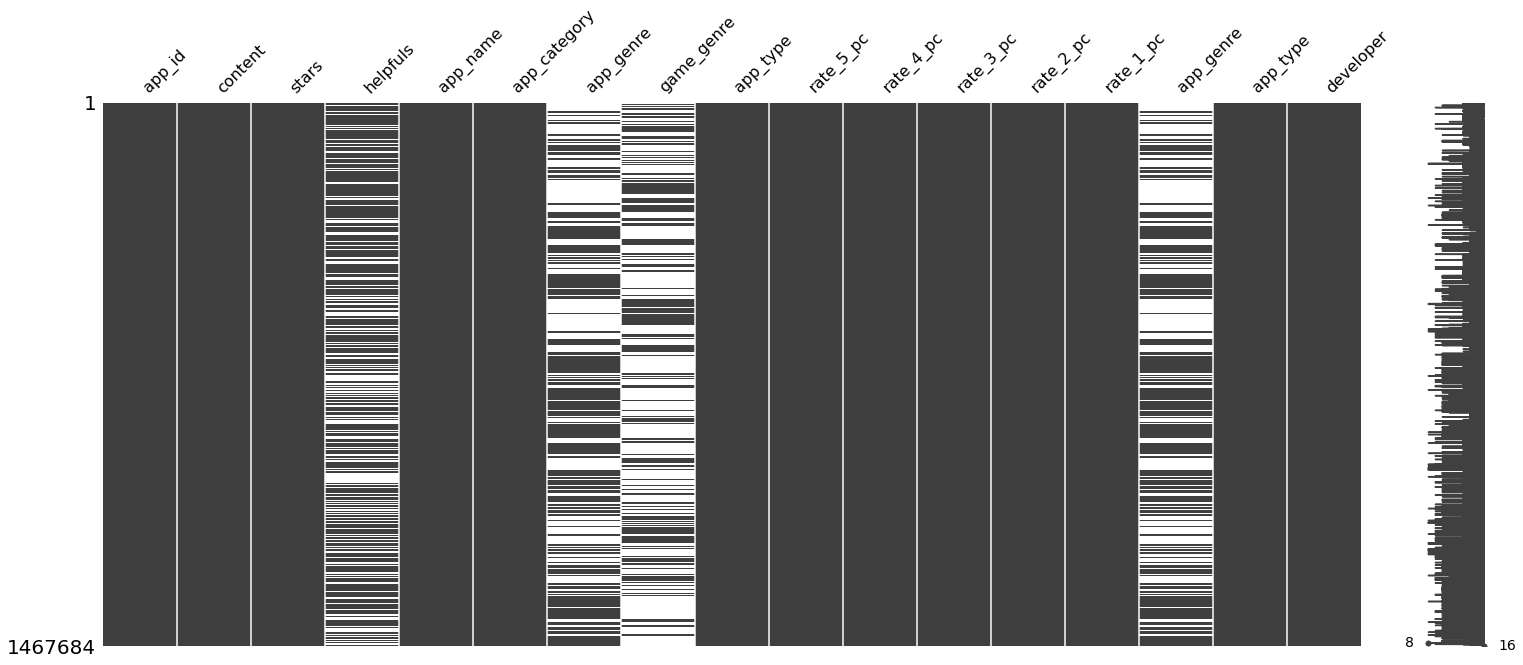

In [ ]:
# visual inspection of missing values
msno.matrix(comment_df);

There are many missing `helpful` values. But apart from that, there are no other missing values.

Convert the `Stars` to category datatype as 1, 2, 3, 4 and 5 are valid options.  

In [ ]:
comment_df["stars"] = comment_df["stars"].astype('category')

comment_df.dtypes

app_id             int64
content           object
stars           category
helpfuls         float64
app_name          object
app_category    category
app_genre       category
game_genre      category
app_type          object
rate_5_pc        float64
rate_4_pc        float64
rate_3_pc        float64
rate_2_pc        float64
rate_1_pc        float64
app_genre       category
app_type          object
developer         object
dtype: object

## Step 3: Perform exploratory analysis & visualization

1. Compute the mean, sum, range and other interesting statistics for numeric columns
2. Explore relationship between columns using scatter plots, bar charts etc.
3. Make a note of interesting insights from the exploratory analysis
4. Your notebook should contain at least 8 graphs & 4 different types of graphs

<img src="https://www.perceptive-analytics.com/wp-content/uploads/2019/10/37-768x512.png" 
alt="GooglePlay" 
style="width: 800px; margin-left: 50; margin-right: 50;"/>

<a href="https://www.perceptive-analytics.com/wp-content/uploads/2019/10/37-768x512.png">Image Source</a>

Let's have a look at the numerical values in the dataset

In [ ]:
app_df.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

count        mean          std     min       25%        50%  \
app_id     53653.00    26867.26     15520.20    1.00  13426.00   26862.00   
cost_usd   53653.00        0.44         4.03    0.00      0.00       0.00   
iap_usd    24272.00        2.52         8.20    0.00      1.00       1.10   
installs   53653.00  3230915.25  63110103.19  500.00  10000.00  100000.00   
size_mb    53653.00       25.39        27.30   -1.00      5.00      15.00   
reviews    47684.00    71536.72   1085985.05    5.00    176.00    1269.00   
rating     47684.00        4.23         0.48    1.00      4.00       4.30   
rate_5_pc  47684.00       68.85        14.55    0.00     61.35      70.42   
rate_4_pc  47684.00       11.90         6.28    0.00      7.79      11.48   
rate_3_pc  47684.00        5.69         3.82    0.00      3.17       5.34   
rate_2_pc  47684.00        2.93         2.97    0.00      0.83       2.26   
rate_1_pc  47684.00       10.63        10.42    0.00      3.79       7.80   

                 75%            max  
app_id      40300.00       53751.00  
cost_usd        0.00         391.30  
iap_usd         2.30         356.50  
installs   500000.00  5000000000.00  
size_mb        39.00         354.00  
reviews     10456.50   109817549.00  
rating          4.50           5.00  
rate_5_pc      78.12         100.00  
rate_4_pc      15.53          86.21  
rate_3_pc       7.64          66.67  
rate_2_pc       3.97          50.25  
rate_1_pc      14.00         100.00

##### Observations
- Most of the app cost 0 USD (free), and the most expensive app is 391 USD. 
- If the App has In-App-Purchase option, median price point is 1.1 USD. 
- Media app size is 15 MB, and max can go upto 354 MB.
- Median app reviews aare around 1250. It has a very high standard deviation, so the data may have outliers.
- Ratings vary from 1 to 5, and average rating is 4.23. This looks higher than I was expecting, so will check again.

Covariance
Covariance is a measure of how much two random variables vary together.

If two variables are independent, their covariance is 0. However, a covariance of 0 does not imply that the variables are independent.

- (+) : positive relation
- (-) : negtive relation

In [ ]:
app_df.cov()

app_id      cost_usd       iap_usd      installs  \
app_id     2.408765e+08  2.452926e+03  4.589135e+03 -5.755515e+10   
cost_usd   2.452926e+03  1.623068e+01  4.079788e-01 -1.415129e+06   
iap_usd    4.589135e+03  4.079788e-01  6.731654e+01 -3.780766e+06   
installs  -5.755515e+10 -1.415129e+06 -3.780766e+06  3.982885e+15   
size_mb   -5.207101e+04 -7.834945e-01 -5.997402e+00 -1.084698e+07   
reviews   -1.163929e+09 -2.842026e+04 -1.275918e+05  4.687909e+13   
rating     1.329181e+02  1.276905e-03 -4.760526e-02  2.835153e+05   
rate_5_pc -3.749355e+02 -6.553190e-01  7.089956e-01  9.506825e+06   
rate_4_pc  4.934028e+03  7.400158e-01 -2.112167e+00 -2.017585e+06   
rate_3_pc -3.556890e+02  6.471796e-02 -7.852763e-01 -3.814655e+05   
rate_2_pc  3.543215e+02  2.865241e-01 -5.441074e-02 -1.746364e+06   
rate_1_pc -4.557736e+03 -4.359387e-01  2.242857e+00 -5.361406e+06   

                size_mb       reviews         rating     rate_5_pc  \
app_id    -5.207101e+04 -1.163929e+09     132.918149 -3.749355e+02   
cost_usd  -7.834945e-01 -2.842026e+04       0.001277 -6.553190e-01   
iap_usd   -5.997402e+00 -1.275918e+05      -0.047605  7.089956e-01   
installs  -1.084698e+07  4.687909e+13  283515.269481  9.506825e+06   
size_mb    7.452024e+02  3.375559e+05      -0.632115 -1.034906e+01   
reviews    3.375559e+05  1.179364e+12    9880.010975  2.987038e+05   
rating    -6.321152e-01  9.880011e+03       0.227677  6.399237e+00   
rate_5_pc -1.034906e+01  2.987038e+05       6.399237  2.116023e+02   
rate_4_pc -1.149365e+01 -1.707684e+04       0.006055 -3.286059e+01   
rate_3_pc  3.885231e+00 -3.770852e+04      -0.803429 -3.368343e+01   
rate_2_pc  3.817862e+00 -6.120793e+04      -0.899325 -2.784422e+01   
rate_1_pc  1.413962e+01 -1.827102e+05      -4.702538 -1.172140e+02   

              rate_4_pc      rate_3_pc     rate_2_pc     rate_1_pc  
app_id     4.934028e+03    -355.689021  3.543215e+02 -4.557736e+03  
cost_usd   7.400158e-01       0.064718  2.865241e-01 -4.359387e-01  
iap_usd   -2.112167e+00      -0.785276 -5.441074e-02  2.242857e+00  
installs  -2.017585e+06 -381465.517365 -1.746364e+06 -5.361406e+06  
size_mb   -1.149365e+01       3.885231  3.817862e+00  1.413962e+01  
reviews   -1.707684e+04  -37708.516254 -6.120793e+04 -1.827102e+05  
rating     6.054594e-03      -0.803429 -8.993247e-01 -4.702538e+00  
rate_5_pc -3.286059e+01     -33.683431 -2.784422e+01 -1.172140e+02  
rate_4_pc  3.941560e+01       6.417042  7.446769e-01 -1.371672e+01  
rate_3_pc  6.417042e+00      14.599662  4.304300e+00  8.362428e+00  
rate_2_pc  7.446769e-01       4.304300  8.835003e+00  1.396024e+01  
rate_1_pc -1.371672e+01       8.362428  1.396024e+01  1.086081e+02

Correlation
Correlation is a standardized version of covariance.
Between -1 and 1
Zero = Not correlated
(+) : positive relation
(-) : negtive relation

In [ ]:
app_df.corr()

app_id  cost_usd   iap_usd  installs   size_mb   reviews  \
app_id     1.000000  0.039230  0.036287 -0.058761 -0.122903 -0.069173   
cost_usd   0.039230  1.000000  0.017467 -0.005566 -0.007124 -0.006334   
iap_usd    0.036287  0.017467  1.000000 -0.011532 -0.023971 -0.015434   
installs  -0.058761 -0.005566 -0.011532  1.000000 -0.006296  0.644939   
size_mb   -0.122903 -0.007124 -0.023971 -0.006296  1.000000  0.011196   
reviews   -0.069173 -0.006334 -0.015434  0.644939  0.011196  1.000000   
rating     0.017979  0.000648 -0.014767  0.008877 -0.047718  0.019067   
rate_5_pc -0.001664 -0.010903  0.007151  0.009764 -0.025626  0.018908   
rate_4_pc  0.050723  0.028527 -0.046232 -0.004801 -0.065943 -0.002505   
rate_3_pc -0.006008  0.004099 -0.028836 -0.001492  0.036626 -0.009087   
rate_2_pc  0.007694  0.023330 -0.002683 -0.008778  0.046266 -0.018962   
rate_1_pc -0.028226 -0.010124  0.032153 -0.007686  0.048871 -0.016144   

             rating  rate_5_pc  rate_4_pc  rate_3_pc  rate_2_pc  rate_1_pc  
app_id     0.017979  -0.001664   0.050723  -0.006008   0.007694  -0.028226  
cost_usd   0.000648  -0.010903   0.028527   0.004099   0.023330  -0.010124  
iap_usd   -0.014767   0.007151  -0.046232  -0.028836  -0.002683   0.032153  
installs   0.008877   0.009764  -0.004801  -0.001492  -0.008778  -0.007686  
size_mb   -0.047718  -0.025626  -0.065943   0.036626   0.046266   0.048871  
reviews    0.019067   0.018908  -0.002505  -0.009087  -0.018962  -0.016144  
rating     1.000000   0.921952   0.002021  -0.440673  -0.634093  -0.945674  
rate_5_pc  0.921952   1.000000  -0.359817  -0.606017  -0.643979  -0.773194  
rate_4_pc  0.002021  -0.359817   1.000000   0.267503   0.039905  -0.209645  
rate_3_pc -0.440673  -0.606017   0.267503   1.000000   0.378990   0.210005  
rate_2_pc -0.634093  -0.643979   0.039905   0.378990   1.000000   0.450670  
rate_1_pc -0.945674  -0.773194  -0.209645   0.210005   0.450670   1.000000

### Explore - Top 10 Games and Apps
- List top 10 Apps and Games based on installs

In [ ]:
# top 10 Apps based on installs - select only the necessary columns 
app_df[['app_name', 'developer', 'app_genre', 'app_type', 'installs', 'installs_range']][app_df.app_category == "App"].sort_values(
                                                                                                                        by='installs', 
                                                                                                                        ascending=False).reset_index().head(10)

index                                           app_name  \
0   3150                                 WhatsApp Messenger   
1   2391                                           Facebook   
2    898                                  Google Play Music   
3   1309                       Google Chrome: Fast & Secure   
4    911                                            YouTube   
5    640                                             Google   
6    627                          Maps - Navigate & Explore   
7  14837                                Samsung One UI Home   
8    772  Google Play Books - Ebooks, Audiobooks, and Co...   
9  34964                                     Samsung Health   

                       developer                app_genre app_type  \
0                  WhatsApp Inc.            Communication     Free   
1                       Facebook                   Social     Free   
2                     Google LLC            Music & Audio     Free   
3                     Google LLC            Communication     Free   
4                     Google LLC  Video Players & Editors     Free   
5                     Google LLC                    Tools     Free   
6                     Google LLC           Travel & Local     Free   
7  Samsung Electronics Co., Ltd.          Personalization     Free   
8                     Google LLC        Books & Reference     Free   
9  Samsung Electronics Co., Ltd.         Health & Fitness     Free   

       installs installs_range  
0  5.000000e+09            5B+  
1  5.000000e+09            5B+  
2  5.000000e+09            5B+  
3  5.000000e+09            5B+  
4  5.000000e+09            5B+  
5  5.000000e+09            5B+  
6  5.000000e+09            5B+  
7  1.000000e+09            1B+  
8  1.000000e+09            1B+  
9  1.000000e+09            1B+

In [ ]:
# top 10 Games based on installs - select only the necessary columns 
app_df[['app_name', 'developer', 'game_genre', 'app_type', 'installs', 'installs_range']][app_df.app_category == "Game"].sort_values(
                                                                                                                          by='installs', 
                                                                                                                          ascending=False).reset_index().head(10)

index                      app_name  \
0   1318              Candy Crush Saga   
1    611                Subway Surfers   
2     25                  Temple Run 2   
3    336                My Talking Tom   
4   1978                           Pou   
5    751             My Talking Angela   
6     52  Garena Free Fire: Wonderland   
7    131                   8 Ball Pool   
8   3065             Hill Climb Racing   
9    608                    Temple Run   

                                developer game_genre app_type      installs  \
0                                    King     Casual     Free  1.000000e+09   
1                              SYBO Games     Arcade     Free  1.000000e+09   
2                          Imangi Studios     Action     Free  5.000000e+08   
3                         Outfit7 Limited     Casual     Free  5.000000e+08   
4                                   Zakeh     Casual     Free  5.000000e+08   
5                         Outfit7 Limited     Casual     Free  5.000000e+08   
6  GARENA INTERNATIONAL I PRIVATE LIMITED     Action     Free  5.000000e+08   
7                            Miniclip.com     Sports     Free  5.000000e+08   
8                              Fingersoft     Racing     Free  5.000000e+08   
9                          Imangi Studios     Arcade     Free  5.000000e+08   

  installs_range  
0            1B+  
1            1B+  
2          500M+  
3          500M+  
4          500M+  
5          500M+  
6          500M+  
7          500M+  
8          500M+  
9          500M+

##### Observations
- App space is dominated by *Facebook (now Meta), Google and Samsung*. All in top 10 Apps are developed by these three.
- Users like to play endless runner games - *Temple Run, Temple Run 2* and *Subway Surfer*. 
- Outfit7 Limited's talking simulation games are popular, likely amoung young amoung kids.

### Explore - What is the install base for these Apps and Games?

In [ ]:
fig = px.histogram(app_df.sort_values( by="installs_range"), 
                                        x="installs_range", 
                                        color="app_type",
                                        facet_col = "app_category",
                                        title='Installs: By Category (Game/ App) and App Type (Paid/ Free)')
fig.update_layout(title_font_size=20)  
fig.update_layout(height=600)
fig.show()

In [ ]:
# Total installs of Apps and Games seperately
app_games_installs = app_df.groupby('app_category')['installs'].sum().astype('int64')

# count of Apps and Games
app_games_count = app_df.app_category.value_counts()

print("There are {}x apps as compared to games, and their install base is {}x.".format(
    (app_games_count[0]/app_games_count[1]).round(1), 
    (app_games_installs[0]/app_games_installs[1]).round(1)))

print("Ballpark installs per App is {}, and for Games is {}.".format(
    int((app_games_installs[0]/app_games_count[0]).round(-3)), 
    int((app_games_installs[1]/app_games_count[1]).round(-3))))    

There are 1.6x apps as compared to games, and their install base is 2.0x.
Ballpark installs per App is 3506000, and for Games is 2785000.


##### Observations:
- Apps has larger install base than Games
- Most of the Games and Apps have within 1M installs.
- There are 1.6x apps as compared to games, and their install base is 2.0x.
- Ballpark installs per App is 3506000, and for Games is 2785000.

### Explore - Size of Apps and Games

Smaller size Apps and Games are convinient for users to download especially if they are on mobile data. 

We will explore what is the typical size of an app in GooglePlay store.

In [ ]:
# filter out the uknown app sizes that are flagged with -1
fig = px.histogram(app_df[app_df["size_mb"] > 0], 
                x="size_mb", 
                nbins = 20,
                hover_data=['app_name'],
                facet_col="app_category",
                labels={'size_mb':'App Size in MB'},
                title='Game Size in MB',
                marginal="box")

# Overlay both histograms
fig.update_layout(bargap=0.1)

fig.update_layout(title_font_size=20)                 
fig.show()

Output hidden; open in https://colab.research.google.com to view.

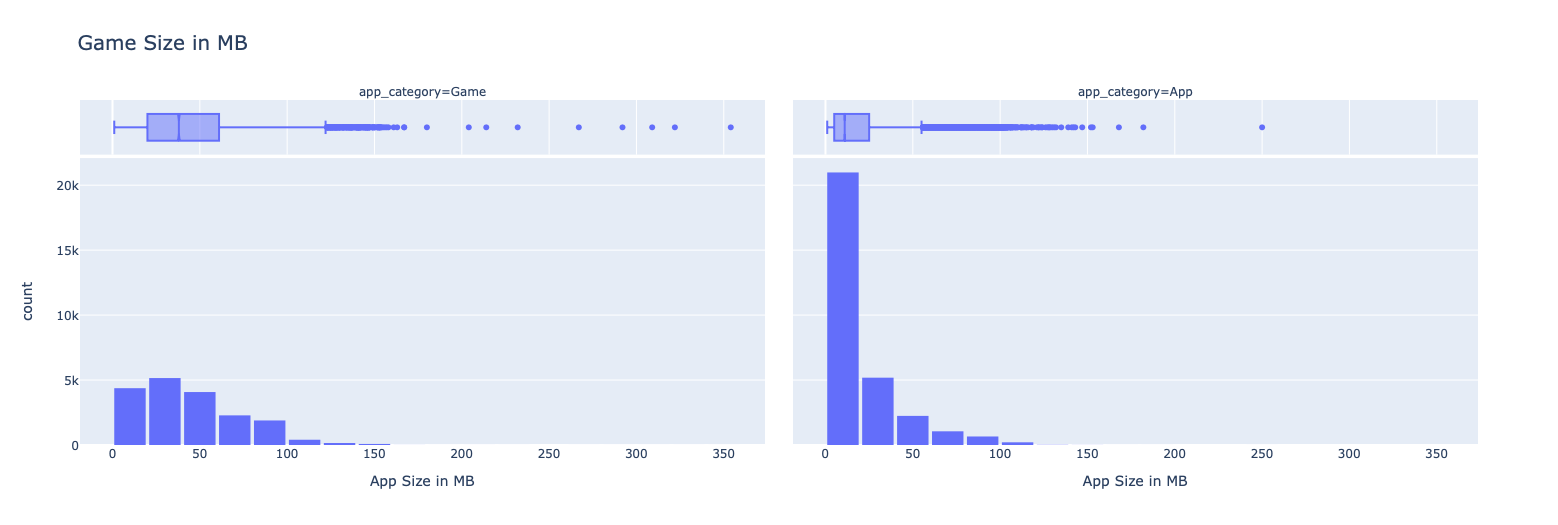

In [ ]:
fig = px.ecdf(app_df[app_df["size_mb"] > 0], 
              x="size_mb", 
              # ecdfnorm=None,
              color="app_category",
              labels={'size_mb':'App Size in MB'},
              title='Game Size in MB')

fig.update_layout(title_font_size=20)  
fig.show()

##### Obeseravions
- Games tend to be larger in size as compared to Apps - 65% of Apps and 92% of Games are less than 50MB.
- Median size for Apps is 11 MB, whereas Games is 38 MB, more than 3x higher. So, Games are generally 3x heavier than Apps.
- Below, we list the apps that are more than 250MB size. Out of 6, 5 are games.

In [ ]:
app_df[app_df.size_mb>=250].iloc[:,0:6].reset_index()

index  app_id                                           app_name  \
0    429     452                           Dream League Soccer 2020   
1   2448    2579                                Heroic - Magic Duel   
2  19049   20149  Eternity Legends - Dynasty Warriors - 3D strategy   
3  23053   23326  The Weight Loss Mindset®:Lose Weight With Hypn...   
4  30930   31702                      Agent A: A puzzle in disguise   
5  33169   34071  CandyBots Kids - ABC 123 World - Learning Academy   

  app_category         genre  app_genre    game_genre  
0         Game        Sports        NaN        Sports  
1         Game      Strategy        NaN      Strategy  
2         Game  Role Playing        NaN  Role Playing  
3          App     Lifestyle  Lifestyle           NaN  
4         Game        Puzzle        NaN        Puzzle  
5         Game           NaN        NaN           NaN

### Explore - User Ratings

Here we will explore how users have rated Apps and Games.

In [ ]:
fig = px.histogram(app_df, 
                    x="rating", 
                    color="app_type",
                    hover_data=['app_name'],
                    facet_col="app_category", 
                    title='Rating of Apps and Games',
                    marginal="box")

fig.update_layout(bargap=0.1)

fig.update_layout(title_font_size=20) 
fig.update_layout(height=500)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

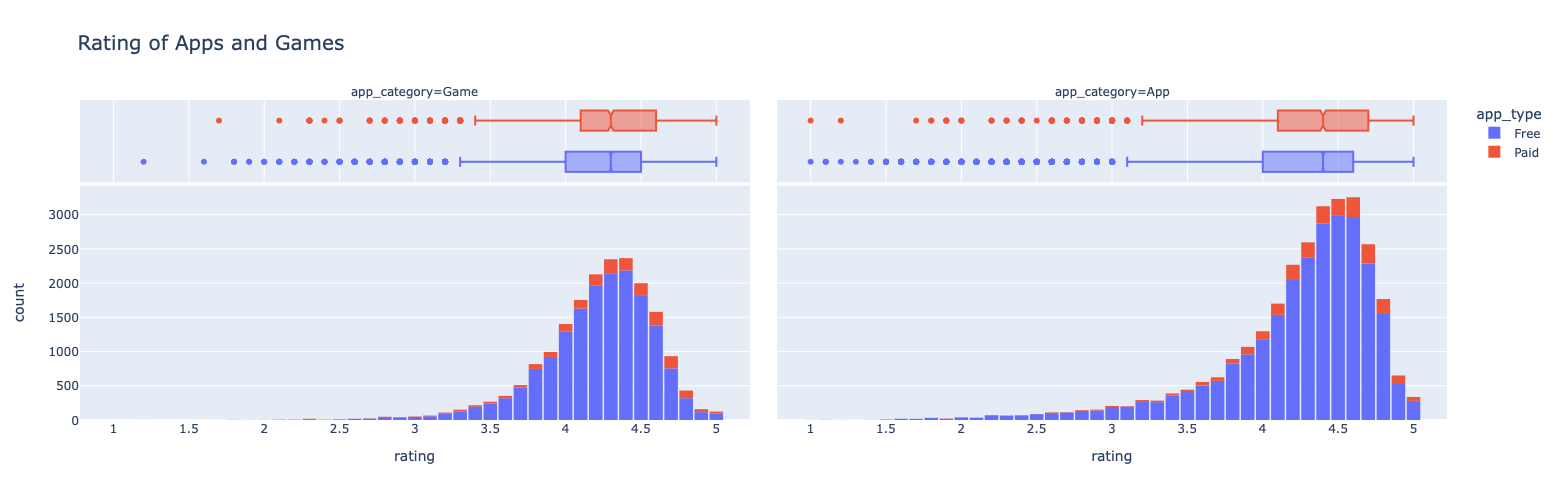

##### Observations
- Generally, Paid apps have righer ratings than Free apps, but from frewer users.
- Apps and Games have very close median rating of 4.3 and 4.4.

### Explore - Number of Reviews

After checking the ratings, we will now dig deeper into user reviews.

In [ ]:
# pie chart of App and Games reviews 
fig = px.pie(app_df, 
            values="reviews", 
            names="app_category", 
            title='Reviews: App and Games',
            hole=.3)
fig.update_layout(title_font_size=20) 
fig.show()

##### Observations
- 52% reives are about Apps, and remaining 48% belong to Games.

In [ ]:
# plot histogram of Apps and Games reviews
# exclude the top 10 percentile as outlier
fig = px.histogram(app_df[app_df.reviews <= app_df.reviews.quantile(0.90)], 
                    x="reviews", 
                    nbins = 25,
                    hover_data=['app_name'],
                    # color="app_type", 
                    labels={
                      "count": "Number of Apps",
                      "reviews": "Number of user reviews"
                    },
                    facet_col="app_category", 
                    marginal="box")

fig.update_layout(yaxis_title="Number of Apps") 
fig.update_layout(bargap=0.1)

fig.update_layout(height=500)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

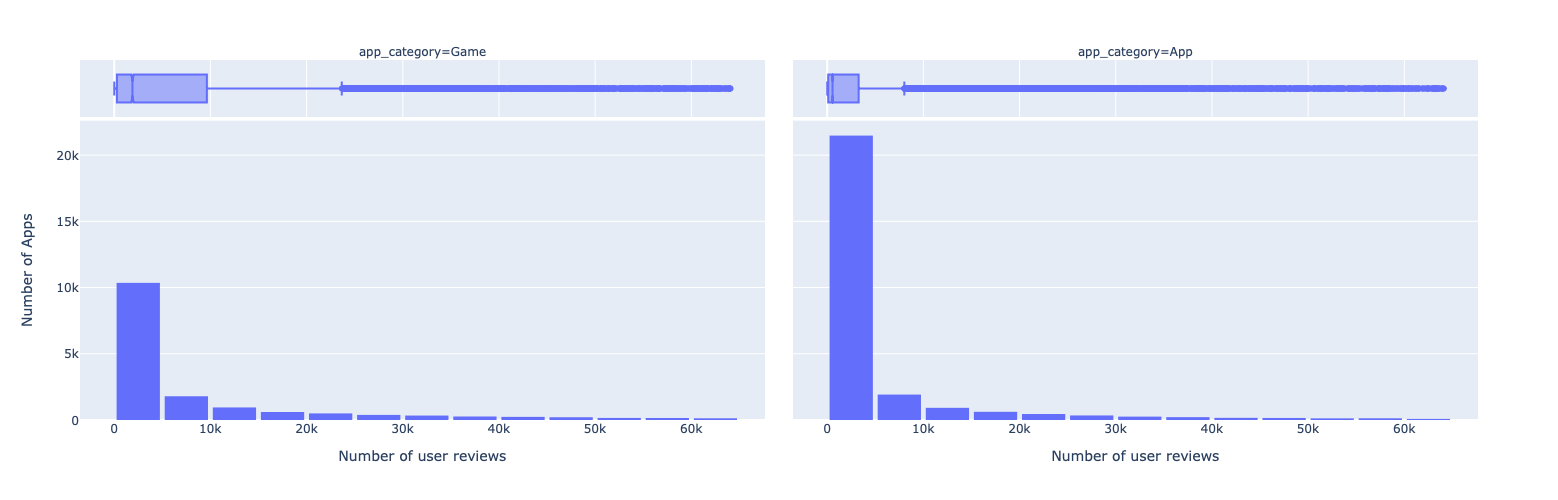

##### Observations
- Games have a median of 1898 user reviews, whereas Apps have 556.

In [ ]:
# aggregate reviews by app category
app_car_reviews_df = app_df.groupby(["app_category"]).agg({'reviews': ['count', np.sum]}).astype('int64').reset_index()

# the table header is multiindex, so renaiming it
app_car_reviews_df.columns = ['app_category', 'app_count', 'app_reviews']

app_car_reviews_df["reviews_per_app"] = (app_car_reviews_df["app_reviews"]/ app_car_reviews_df["app_count"]).astype('int64')

app_car_reviews_df

app_category  app_count  app_reviews  reviews_per_app
0          App      28741   1783624935            62058
1         Game      18943   1627531818            85917

##### Observations
- On an average, we have about 86k revies per Game, and 62k reviews per App.

### Explore - Relation between Ratings and Reviews
Let's plot them to see any relation by visually scanning it.

In [ ]:
fig = px.scatter(app_df[app_df.reviews <= app_df.reviews.quantile(0.95)], 
                 x='rating', 
                 y='reviews', 
                 opacity=0.5, 
                 hover_data=['app_name'], 
                 title='Ratings and Reviews',
                 facet_col="app_category")
fig.update_traces(marker_size=5)
fig.update_layout(height=500)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

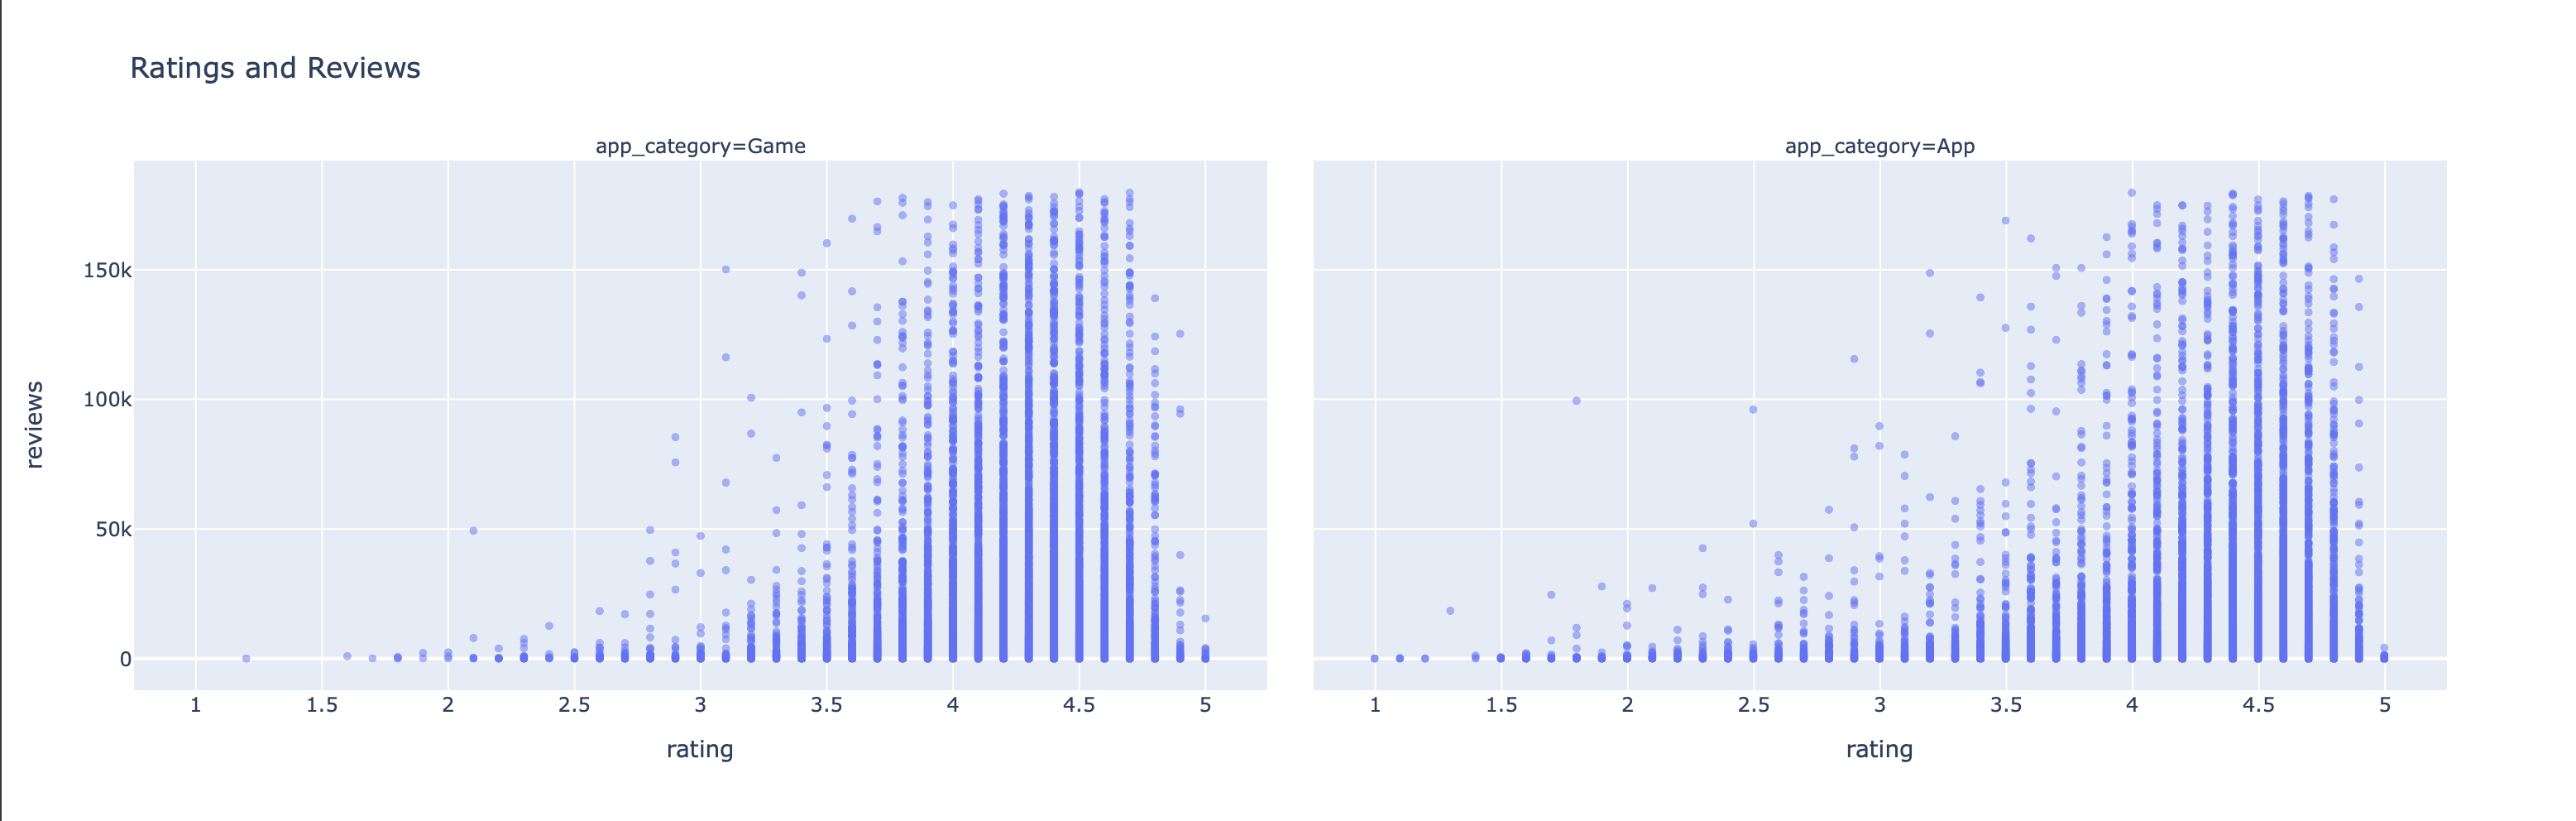

##### Observations
- Lower rated Apps and Games doesn't have many reviews.
- For Apps and Games with 3.5+ ratings, reviews are spread and not possible to find any pattern visually.

##### Observations
- 52% reives are about Apps, and remaining 48% belong to Games.
- Games have a median of 1898 user reviews, whereas Apps have 556.  
- On an average, we have about 86k revies per Game, and 62k reviews per App.

### Explore - Which comments are considered helpful by users?

In [ ]:
# Aggregate Reviews 
star_helpful_df = comment_df.groupby(["stars"]).agg({"helpfuls": [np.sum]}).reset_index()

# the table header is multiindex, so renaiming it
star_helpful_df.columns = star_helpful_df.columns.get_level_values(0)

star_helpful_df

stars    helpfuls
0   1.0   6083189.0
1   2.0   2227948.0
2   3.0   2766244.0
3   4.0   4137591.0
4   5.0  11929653.0

In [ ]:
fig = px.bar(star_helpful_df, 
                    x="stars", 
                    y = "helpfuls",
                    title="Stars and Reviews")

fig.update_layout(title_font_size=20) 
fig.update_layout(height=500)
fig.show()

##### Observations
- Most of the helpful votes are for 5-star reviews. Next most upvoted is 1-Star reviees. 

### Explore - Stydy the distributtion of Apps and Games
- Plot the split between Appsn ad Games
- Segment Games and Apps by their genre and plot

In [ ]:
# show how many Apps and Games
fig = px.bar(app_df, 
             x= app_df.app_category.value_counts().values,
             y= app_df.app_category.value_counts().index,
             labels={
                     "x": "No. of Apps",
                     "y": "App Category",
                 },
             title= "How many Games and Apps?",
             template = "seaborn")
fig.update_layout(title_font_size=20) 
fig.update_layout(yaxis=dict(autorange="reversed")) 
fig.update_layout(height=300)    
fig.show()

In [ ]:
# apps by genre
fig = px.bar(app_df, 
             x= app_df.app_genre.value_counts().values,
             y= app_df.app_genre.value_counts().index,
             labels={
                     "x": "No. of Apps",
                     "y": "App Genere",
                 },
             title= "Apps by Genre",
             template = "seaborn")

fig.update_layout(title_font_size=20)
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.update_layout(height=800)
fig.show()

# table for validation 
# app_df[app_df["app_category"] == "App"]["app_genre"].value_counts()

In [ ]:
# games by genre
fig = px.bar(app_df, 
             x= app_df.game_genre.value_counts().values,
             y= app_df.game_genre.value_counts().index,
             labels={
                     "x": "No. of Apps",
                     "y": "Game Genere",
                 },
             title= "Games by Genre",
             template = "seaborn")

fig.update_layout(title_font_size=20)
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

# table for validation
# app_df[app_df["app_category"] == "Game"]["game_genre"].value_counts()

### Explore: Who are the top App developers and what is their install base?

List the top developers and see what is their market share. Does winner takes it all?

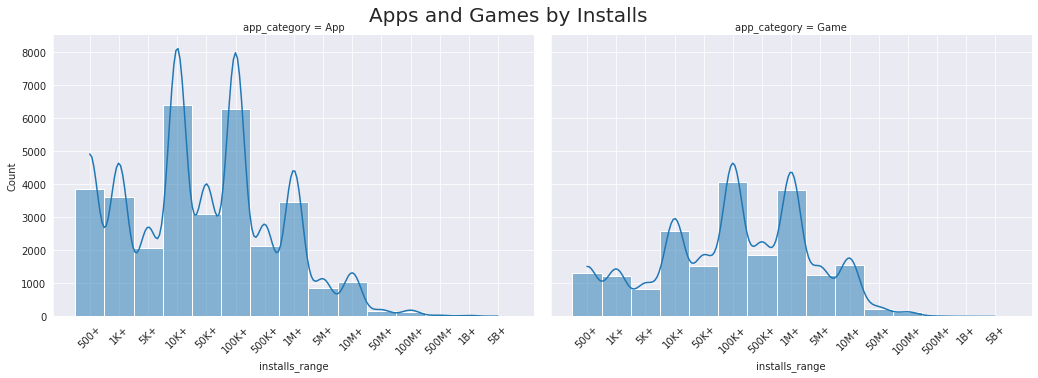

In [ ]:
# install base distribuion
sns.set_style("darkgrid")
g = sns.displot(data=app_df, 
                x="installs_range", 
                col="app_category", 
                kde=True)
g.set_xticklabels(rotation=45)
g.figure.set_size_inches(15,5)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle("Apps and Games by Installs", fontsize=20);


##### Observations
- It's seen in the plot that the install base distribution is skewed towards lower figures - only a handful of Apps and Games see 10M+ installs.

### Explore - Content Rating of Apps
Suitability of Apps for age groups

In [ ]:
fig = px.histogram(app_df, 
                x="content_rating", 
                color="app_category",
                title='Content Rating',
                marginal="violin")

fig.update_layout(title_font_size=20)                 
fig.show()

In [ ]:
app_df[app_df["content_rating"] == "Rated for 18+"].sort_values(by="installs", ascending = False).head(10)

app_id                                           app_name app_category  \
8          11     Sniper 3D: Fun Offline Gun Shooting Games Free         Game   
313       330                              Vegas Crime Simulator         Game   
1470     1551                                             Tinder          App   
36158   37245  Badoo — Dating App to Chat, Date & Meet New Pe...          App   
499       528                                 Grand Gangsters 3D         Game   
10211   10805     Messenger for Messages,Chat,Video,Text,Call ID          App   
18         21                     Gangstar Vegas: World of Crime         Game   
5428     5730                        SKOUT - Meet, Chat, Go Live          App   
5419     5722                     MeetMe: Chat & Meet New People          App   
1430     1509                                            LOVOO ®          App   

            genre  app_genre  game_genre app_type  cost_usd  iap_usd  \
8          Action        NaN      Action     Free       0.0      1.0   
313    Simulation        NaN  Simulation     Free       0.0      0.3   
1470    Lifestyle  Lifestyle         NaN     Free       0.0      0.4   
36158      Social     Social         NaN     Free       0.0      1.1   
499        Action        NaN      Action     Free       0.0      1.9   
10211      Social     Social         NaN     Free       0.0      1.4   
18         Action        NaN      Action     Free       0.0      0.3   
5428       Social     Social         NaN     Free       0.0      0.9   
5419       Social     Social         NaN     Free       0.0      0.9   
1430       Social     Social         NaN     Free       0.0      0.9   

          installs  ...     reviews  rating  rate_5_pc  rate_4_pc  rate_3_pc  \
8      100000000.0  ...  12596370.0     4.5    71.4286   16.42860    6.42857   
313    100000000.0  ...   1050043.0     4.1    67.5676    8.10811    6.08108   
1470   100000000.0  ...   3823269.0     3.7    52.3560   15.18320    6.28272   
36158  100000000.0  ...   4897221.0     4.2    69.9301   10.48950    5.59441   
499     50000000.0  ...    473812.0     4.0    64.1026    8.97436    7.05128   
10211   50000000.0  ...    142049.0     4.2    68.9655   11.03450    6.20690   
18      50000000.0  ...   5752991.0     4.3    74.6269    8.95522    4.47761   
5428    50000000.0  ...   1160137.0     4.3    74.0741    6.66667    4.44444   
5419    50000000.0  ...   1442772.0     4.0    62.8931   10.69180    6.28931   
1430    50000000.0  ...    980989.0     4.0    61.3497   10.42940    7.36196   

       rate_2_pc  rate_1_pc  content_rating  update_date  \
8        1.42857    4.28571   Rated for 18+   2020-04-03   
313      4.05405   14.18920   Rated for 18+   2020-03-26   
1470     3.66492   22.51310   Rated for 18+   2020-04-16   
36158    2.79720   11.18880   Rated for 18+   2020-04-25   
499      4.48718   15.38460   Rated for 18+   2019-11-08   
10211    2.75862   11.03450   Rated for 18+   2020-04-19   
18       2.23881    9.70149   Rated for 18+   2020-03-11   
5428     2.22222   12.59260   Rated for 18+   2020-04-16   
5419     3.77358   16.35220   Rated for 18+   2020-04-15   
1430     4.29448   16.56440   Rated for 18+   2020-04-17   

                                               developer  
8                                     Fun Games For Free  
313                                           Naxeex LLC  
1470                                              Tinder  
36158                                              Badoo  
499                                   Doodle Mobile Ltd.  
10211  Messenger Pro : Free Texts & Messages by AppyHigh  
18                                           Gameloft SE  
5428                                          Skout Inc.  
5419                                          MeetMe.com  
1430                                          LOVOO GmbH  

[10 rows x 22 columns]

##### Observations
- Both Apps and Games are mostly designed for 3+ years age. 
- Dating Apps nad violent Action games are 'Rated for 18+'

# Step 4: Ask & answer questions about the data

1. Ask at least 8 interesting questions about your dataset
2. Answer the questions either by computing the results using Numpy/Pandas or by plotting graphs using Matplotlib/Seaborn/Plotly/Folium
3. Create new columns, merge multiple dataset and perform grouping/aggregation wherever necessary
4. For each question, summarize the key insight from the analysis or visualization in simple words

<img src="https://www.perceptive-analytics.com/wp-content/uploads/2019/10/46-768x512.png" 
alt="GooglePlay" 
style="width: 800px; margin-left: 50; margin-right: 50;"/>

<a href="https://www.perceptive-analytics.com/wp-content/uploads/2019/10/46-768x512.png*">Image source</a>

### Q&A 1: What is Free vs Paid app distribution in GooglePlay store? 
- Common knowledge is the GooglePlay stroe is mostly populated with free to download apps and games. We shall see that here and drill down deeper into it.

In [ ]:
# create a subset of games dataframe
app_games_df = app_df.where(app_df.app_category == "Game")

fig = px.pie(app_games_df, 
            values=app_games_df.app_type.value_counts().values, 
            names=app_games_df.app_type.value_counts().index, 
            title='Games: Free and Paid',
            hole=.3)

fig.update_layout(title_font_size=20) 
fig.show()

In [ ]:
# create a subset of non-game apps dataframe
app_apps_df = app_df.where(app_df.app_category == "App")

fig = px.pie(app_apps_df, 
            values=app_apps_df.app_type.value_counts().values, 
            names=app_apps_df.app_type.value_counts().index, 
            title='Apps: Free and Paid',
            hole=.3)
fig.update_layout(title_font_size=20) 
fig.show()

##### Findings:
- About 90% of both Apps and Games are free; less than 10% are purchased with real money.

This matches with information avalibale online - 
> *As of November 2022, around 97 percent of all Android applications were available for free, while three percent required payment. Overall, the number of free apps available on the Google Play Store has remained higher than the number of paid apps in the examined period.* <a href="https://www.statista.com/statistics/266211/distribution-of-free-and-paid-android-apps/">Source</a>


### Q&A 2: What is Apps vs Games distribution in GooglePlay store?

Let's dive deep into how different types of apps are live in GooglePlay store. This will give us an idea of an overall trend if we compare this with a similar list for last few years.

Finally, we will make an interactive chart for anyone to explore the numbers.

In [ ]:
# create a new dataset with the required columns
app_cat_gen_df = app_df.iloc[:, 0:4]
app_cat_gen_df.sample(5)

app_id                                           app_name app_category  \
20545   21730                                      Zombie Cutter         Game   
17427   18434          Marrakesh's Best – A Morocco Travel Guide          App   
43262   44799                     Tawseelat Qatar: Food Delivery          App   
52689   44318  Red Waypoint PRO for DJI (Mavic / Spark / Phan...          App   
9279     9823                                         CasaFacile          App   

                   genre  
20545             Arcade  
17427     Travel & Local  
43262       Food & Drink  
52689  Maps & Navigation  
9279           Lifestyle

In [ ]:
# create an aggregate dataframe with count of apps for Apps/ Ganes, by their genre
app_cat_gen_agg_df = pd.pivot_table(app_cat_gen_df, 
                                    index = ['app_category', 'genre'], values=['app_id'], 
                                    aggfunc={np.count_nonzero}).reset_index().rename(columns={'count_nonzero': 'count_genre'})

# the resulting dataframe has multi-level index, so we have to restructure it
app_cat_gen_agg_df.columns = ['app_category', 'genre', 'count_genre']
app_cat_gen_agg_df.sample(5)

app_category              genre  count_genre
31         Game             Action       1320.0
15          App   Libraries & Demo        107.0
39         Game              Music        166.0
13          App   Health & Fitness       1752.0
17          App  Maps & Navigation        541.0

In [ ]:
# Create an interactive sunburst chart 
fig = px.sunburst(data_frame = app_cat_gen_agg_df, 
                    path=['app_category', 'genre'], 
                    values='count_genre',
                    title = "Apps and Games Genre",
                    template="seaborn")

fig.update_layout(title_font_size = 25,
                    height=800)
fig.show()

In [ ]:
app_df[["game_genre", "app_genre"]].describe().T

count unique        top  freq
game_genre  15434     17     Puzzle  2493
app_genre   33200     31  Education  3756

##### Findings:
- There are 2x more Apps than Games.
- There are 31 generes of Apps and 17 genres of Games 

> *A mobile app developer has to weigh the pros and cons of developing a new App - there are plenty of both demand and supply. But not all apps can recover even the development cost! It could end up costing you over $25,000 to design, develop, and deploy a good-quality app. All this effort and expenditure is still worth it if you expect a good return on investment (ROI), which you'll want to try your best to estimate before going too far down the app creation path.  <a href="https://www.lifewire.com/is-it-profitable-to-develop-a-mobile-app-2373416">Reference</a>*

### Q&A 3: What are the top App Titles and most popular App Developers?

- We will list the top developers both by install base and by percent of 5-star ratings, which is a reflection of popularity of the game

In [ ]:
# Top 10 Apps by installs 
top_apps_df = app_df[['developer', 'app_name', 'app_type', 'installs_range', 'installs']][app_df.app_category == "App"].sort_values(by='installs_range', 
                                                                                                                                    ascending=False).reset_index().copy(deep=True)
top_apps_df.head(10)

index                      developer  \
0   3150                  WhatsApp Inc.   
1   2391                       Facebook   
2    898                     Google LLC   
3   1309                     Google LLC   
4    911                     Google LLC   
5    640                     Google LLC   
6    627                     Google LLC   
7  14837  Samsung Electronics Co., Ltd.   
8    772                     Google LLC   
9  34964  Samsung Electronics Co., Ltd.   

                                            app_name app_type installs_range  \
0                                 WhatsApp Messenger     Free            5B+   
1                                           Facebook     Free            5B+   
2                                  Google Play Music     Free            5B+   
3                       Google Chrome: Fast & Secure     Free            5B+   
4                                            YouTube     Free            5B+   
5                                             Google     Free            5B+   
6                          Maps - Navigate & Explore     Free            5B+   
7                                Samsung One UI Home     Free            1B+   
8  Google Play Books - Ebooks, Audiobooks, and Co...     Free            1B+   
9                                     Samsung Health     Free            1B+   

       installs  
0  5.000000e+09  
1  5.000000e+09  
2  5.000000e+09  
3  5.000000e+09  
4  5.000000e+09  
5  5.000000e+09  
6  5.000000e+09  
7  1.000000e+09  
8  1.000000e+09  
9  1.000000e+09

In [ ]:
# Top 20 App Developers by installs 
top_app_devs_df = top_apps_df.groupby('developer', as_index=False)[['installs']].sum().sort_values(by='installs', ascending=False).copy(deep=True)
top_app_devs_df['installs'] = top_app_devs_df['installs'].astype('int64')

# add 3 columns for install percent, cumalative installs, and cumalative percent
top_app_devs_df['installs_pc'] = (100 * top_app_devs_df['installs'] / top_app_devs_df['installs'].sum()).round(4)
top_app_devs_df['installs_cum_sum'] = top_app_devs_df['installs'].cumsum()
top_app_devs_df['installs_cum_pc'] = (100 * top_app_devs_df['installs_cum_sum'] / top_app_devs_df['installs'].sum()).round(4)

top_app_devs_df.head(3)

developer     installs  installs_pc  \
4784                      Google LLC  31676000000      27.2143   
10096  Samsung Electronics Co., Ltd.  12440660000      10.6883   
3976                        Facebook   7621700000       6.5482   

       installs_cum_sum  installs_cum_pc  
4784        31676000000          27.2143  
10096       44116660000          37.9026  
3976        51738360000          44.4508

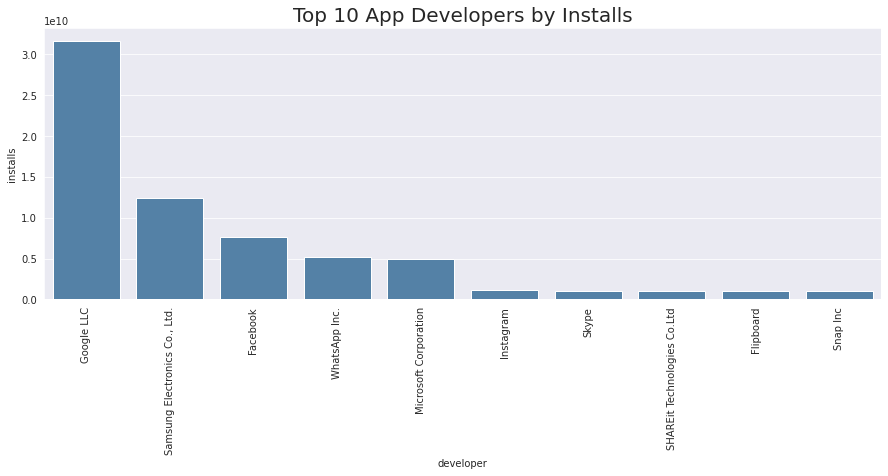

In [ ]:
sns.set_style("darkgrid")

# exclude the outliers as it distors the plot
g = sns.barplot(data=top_app_devs_df.head(10), 
                x="developer", 
                y="installs",
                color='steelblue')

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.axes.set_title("Top 10 App Developers by Installs",fontsize=20)
g.figure.set_size_inches(15,5)

In [ ]:
# Total number of App developers
# top_app_devs_df.developer.nunique()

# Contrast with Google
# top_app_devs_df[top_app_devs_df.installs_cum_pc > 100 - 27.2143

##### Findings
- Top 10 Apps are developed by Facebook (now Meta), Google and Samsung.
- More than 55% of the installs can be attributed to 4 developers - Meta, Google, Samsung and Microsoft, whereas the remaining 45% installs are coming from 14,800 odd developers.
- Google alone accounts for more than 27%, which alone is more than the bottom 14775 apps.
- Samsung has 10% installs, likely due to the pre-installed apps a new phone comes with.

### Q&A 4: What are the top Game Titles and most popular Game Developers?
- We will list the top developers both by install base and by percent of 5-star ratings, which is a reflection of popularity of the game

In [ ]:
# Top 10 Games by installs 
top_games_df = app_df[['developer', 'app_name', 'app_type', 'installs_range', 'installs']][app_df.app_category == "Game"].sort_values(by='installs_range', 
                                                                                                                                      ascending=False).reset_index().copy(deep=True)
top_games_df.head(10)

index                               developer  \
0   1318                                    King   
1    611                              SYBO Games   
2     25                          Imangi Studios   
3    336                         Outfit7 Limited   
4   1978                                   Zakeh   
5    751                         Outfit7 Limited   
6     52  GARENA INTERNATIONAL I PRIVATE LIMITED   
7    131                            Miniclip.com   
8   3065                              Fingersoft   
9    608                          Imangi Studios   

                       app_name app_type installs_range      installs  
0              Candy Crush Saga     Free            1B+  1.000000e+09  
1                Subway Surfers     Free            1B+  1.000000e+09  
2                  Temple Run 2     Free          500M+  5.000000e+08  
3                My Talking Tom     Free          500M+  5.000000e+08  
4                           Pou     Free          500M+  5.000000e+08  
5             My Talking Angela     Free          500M+  5.000000e+08  
6  Garena Free Fire: Wonderland     Free          500M+  5.000000e+08  
7                   8 Ball Pool     Free          500M+  5.000000e+08  
8             Hill Climb Racing     Free          500M+  5.000000e+08  
9                    Temple Run     Free          500M+  5.000000e+08

In [ ]:
# Top 20 Game Developers by installs 
top_game_devs_df = top_games_df.groupby('developer', as_index=False)[['installs']].sum().sort_values(by='installs', ascending=False).copy(deep=True)
top_game_devs_df['installs'] = top_game_devs_df['installs'].astype('int64')

# add 3 columns for install percent, cumalative installs, and cumalative percent
top_game_devs_df['installs_pc'] = (100 * top_game_devs_df['installs'] / top_game_devs_df['installs'].sum()).round(4)
top_game_devs_df['installs_cum_sum'] = top_game_devs_df['installs'].cumsum()
top_game_devs_df['installs_cum_pc'] = (100 * top_game_devs_df['installs_cum_sum'] / top_game_devs_df['installs'].sum()).round(4)

top_game_devs_df.head(10)

developer    installs  installs_pc  installs_cum_sum  \
4075  Outfit7 Limited  1770000000       3.1078        1770000000   
2996             King  1670000000       2.9322        3440000000   
3610     Miniclip.com  1310000000       2.3001        4750000000   
2161      Gameloft SE  1042200000       1.8299        5792200000   
4821       SYBO Games  1005000000       1.7646        6797200000   
2662   Imangi Studios  1000000000       1.7558        7797200000   
5827           VOODOO   880100000       1.5453        8677300000   
1576  ELECTRONIC ARTS   842500000       1.4793        9519800000   
1858       Fingersoft   600000000       1.0535       10119800000   
591           BabyBus   589300000       1.0347       10709100000   

      installs_cum_pc  
4075           3.1078  
2996           6.0400  
3610           8.3401  
2161          10.1700  
4821          11.9346  
2662          13.6904  
5827          15.2357  
1576          16.7150  
1858          17.7685  
591           18.8032

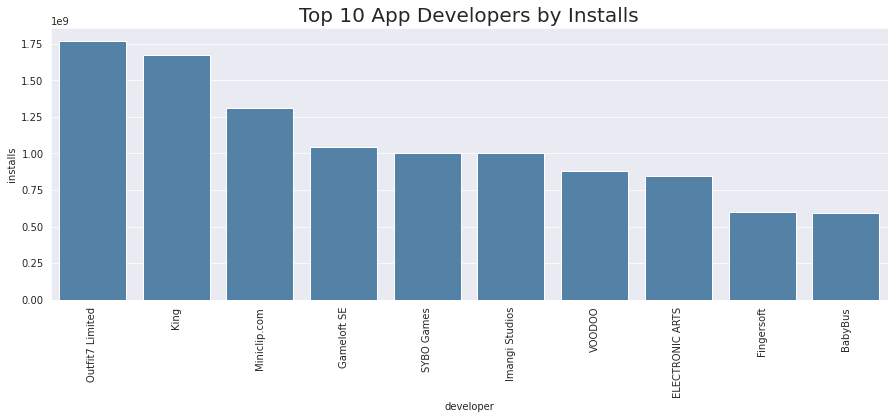

In [ ]:
sns.set_style("darkgrid")

# exclude the outliers as it distors the plot
g = sns.barplot(data=top_game_devs_df.head(10), 
                x="developer", 
                y="installs",
                color='steelblue')

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.axes.set_title("Top 10 App Developers by Installs",fontsize=20)
g.figure.set_size_inches(15,5)

##### Findings
- Top 10 games are from Outfit7, King, Ingagi, SYBO, Garena and Miniclip. It's not as concentrated as in Apps.
- Game developers are not dominated by 2-3 organization as in the came of Apps.

### Q&A 5: Which App and Game genres are most and least appreciated by users?

Find the apps and games with highest 5-Star and 1-Star rating percentage. 

In [ ]:
# create a new dataset with fewer columns
app_ratings_df = app_df[['app_id', 'app_name', 'app_category', 'genre', 'app_genre', 'game_genre', 
                        'rating', 'reviews', 'rate_5_pc', 'rate_4_pc', 'rate_3_pc', 'rate_2_pc', 'rate_1_pc']]

# aggreage 
app_ratings_agg_df = pd.pivot_table(app_ratings_df, 
                                    index = ['app_category', 'genre'], 
                                    values=['rate_5_pc', 'rate_4_pc', 'rate_3_pc', 'rate_2_pc', 'rate_1_pc'],
                                    aggfunc={np.mean}).reset_index()

# the table header is multiindex, so renaiming it
app_ratings_agg_df.columns = app_ratings_agg_df.columns.get_level_values(0)

app_ratings_agg_df.sample(5)  

app_category          genre  rate_1_pc  rate_2_pc  rate_3_pc  rate_4_pc  \
25          App       Shopping  12.927860   2.936465   5.369462  11.470110   
33         Game         Arcade  10.602098   3.282312   6.790977  11.495201   
36         Game         Casino  10.135117   2.139081   5.667471   9.682200   
19          App  Music & Audio   8.582466   2.552719   4.993910  11.621974   
0           App   Art & Design  10.609739   2.916567   5.905008  11.811696   

    rate_5_pc  
25  67.296109  
33  67.829417  
36  72.376138  
19  72.248936  
0   68.756995

Create list of best and worst rated Games and Apps.

In [ ]:
# Apps, sorted by 5-star rating percentage
app_ratings_agg_df[app_ratings_agg_df.app_category == "App"].sort_values(by = ['rate_5_pc', 'rate_4_pc', 'rate_3_pc', 'rate_2_pc', 'rate_1_pc'], ascending=False).head(3)

app_category              genre  rate_1_pc  rate_2_pc  rate_3_pc  \
3           App  Books & Reference   6.218354   1.702571   4.083484   
21          App          Parenting   7.980020   2.211016   4.562372   
8           App          Education   7.113846   2.019762   4.599494   

    rate_4_pc  rate_5_pc  
3   10.350736  77.644857  
21  10.907416  74.339176  
8   12.117780  74.149121

In [ ]:
# Apps, sorted by 1-star rating percentage
app_ratings_agg_df[app_ratings_agg_df.app_category == "App"].sort_values(by = ['rate_1_pc', 'rate_2_pc', 'rate_3_pc', 'rate_4_pc', 'rate_5_pc'], ascending=False).head(3)

app_category                    genre  rate_1_pc  rate_2_pc  rate_3_pc  \
7           App                   Dating  21.169957   3.244245   5.467737   
29          App  Video Players & Editors  15.612905   3.314275   5.527494   
14          App             House & Home  15.167819   3.511080   5.587846   

    rate_4_pc  rate_5_pc  
7    8.058954  62.059111  
29  10.612841  64.932495  
14  11.414925  64.318328

In [ ]:
# Games, sorted by 5-star rating percentage
app_ratings_agg_df[app_ratings_agg_df.app_category == "Game"].sort_values(by = ['rate_5_pc', 'rate_4_pc', 'rate_3_pc', 'rate_2_pc', 'rate_1_pc'], ascending=False).head(3)

app_category        genre  rate_1_pc  rate_2_pc  rate_3_pc  rate_4_pc  \
36         Game       Casino  10.135117   2.139081   5.667471   9.682200   
47         Game         Word   5.671867   2.066258   5.528740  14.360116   
38         Game  Educational   9.553449   2.858147   6.495061  11.311223   

    rate_5_pc  
36  72.376138  
47  72.373022  
38  69.782122

In [ ]:
# Games, sorted by 1-star rating percentage
app_ratings_agg_df[app_ratings_agg_df.app_category == "Game"].sort_values(by = ['rate_1_pc', 'rate_2_pc', 'rate_3_pc', 'rate_4_pc', 'rate_5_pc'], ascending=False).head(3)

app_category   genre  rate_1_pc  rate_2_pc  rate_3_pc  rate_4_pc  rate_5_pc
39         Game   Music  12.495032   3.775918   6.823559  10.962908  65.942584
31         Game  Action  12.290519   3.365408   6.710286  11.279300  66.354493
41         Game  Racing  12.038943   3.468384   6.371579  10.589415  67.531686

In [ ]:
# plot
fig = px.bar(app_ratings_agg_df, 
            x="genre", 
            y=['rate_5_pc', 'rate_4_pc', 'rate_3_pc', 'rate_2_pc', 'rate_1_pc'], 
            labels={
                     "value": "Rating Percentages",
                     "genre": "App and Games Genre",
                     "variable": "Rating Percentages"
                 },
            title="Rating Percentage Distribution Across Genre")
fig.update_layout(title_font_size=20)  
fig.show()

##### Findings
- Books & Reference, Parenting and Education Apps are the most appriciated by users.
- Dating Apps received most of the critical user ratings.
- Casino, Word and Educational Games are the most appriicated by users.
- Music, Action and Racing Games receives maximum 1-star ratings.

### Q&A 6: I want to make a mobile game. What genere of games are most successful?

Lets define suceess as - 
1. Most common genre
2. Maximum reviews and highest ratings

In [ ]:
games_df = app_df[['developer', 'app_name', 'app_type', 'game_genre', 'installs_range', 'installs', 'reviews', 'rating']][app_df.app_category == "Game"]
games_df.sample(5)

developer                              app_name  \
18231                   Saba Games              Solitaire Super Klondike   
52754  My Online Golf Club Limited  Golf Handicap, GPS, Scorecard - MOGC   
51039               Eric Froemling                      BombSquad Remote   
50402                  Ovidiu Caba                  Multiplication Table   
9687           Spin Master Studios                   Dragamonz AR Battle   

      app_type game_genre installs_range   installs  reviews  rating  
18231     Free       Card            1K+     1000.0      9.0     3.8  
52754     Free     Sports           10K+    10000.0    156.0     4.3  
51039     Free     Arcade            1M+  1000000.0  15470.0     4.0  
50402     Free        NaN           10K+    10000.0     57.0     4.3  
9687      Free        NaN           10K+    10000.0     62.0     3.8

In [ ]:
# list the most popular game genres
games_genre_df = pd.DataFrame(games_df["game_genre"].value_counts()).reset_index()
games_genre_df.columns = ['game_genre', 'game_count']
games_genre_df

game_genre  game_count
0         Puzzle        2493
1         Sports        1583
2         Casual        1384
3         Arcade        1368
4         Action        1320
5   Role Playing        1165
6     Simulation        1101
7       Strategy        1093
8           Card         797
9      Adventure         789
10         Board         627
11          Word         600
12        Racing         464
13        Trivia         220
14         Music         166
15        Casino         148
16   Educational         116

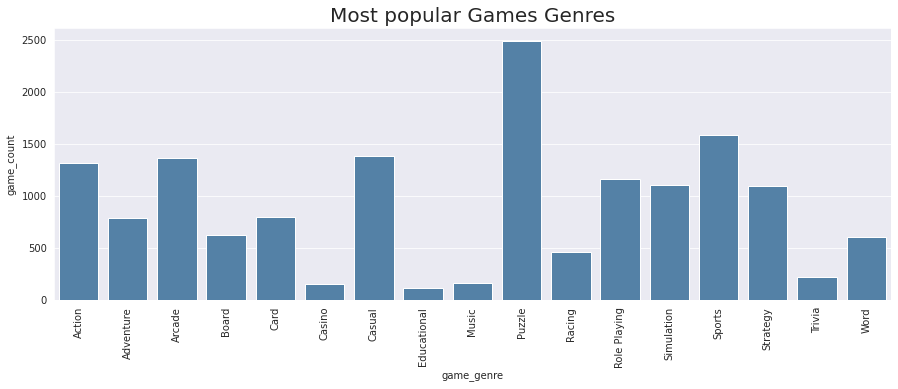

In [ ]:
sns.set_style("darkgrid")

# exclude the outliers as it distors the plot
g = sns.barplot(data=games_genre_df.sort_values(by='game_count', ascending=False), 
                x=games_genre_df.game_genre, 
                y=games_genre_df.game_count,
                color='steelblue')

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.axes.set_title("Most popular Games Genres",fontsize=20)
g.figure.set_size_inches(15,5)

In GooglePlay store, among the games, Puzzle games are the most common one.

Let's list the most popular puzzle games.

In [119]:
games_df[games_df.game_genre == "Puzzle"].sort_values(by='installs', ascending=False).head(5)

developer                      app_name app_type game_genre  \
21664          Focus apps  Brain Out – Can you pass it?     Free     Puzzle   
3063   Big Duck Games LLC                     Flow Free     Free     Puzzle   
7943              Playrix                       Fishdom     Free     Puzzle   
1310         Lion Studios                   Happy Glass     Free     Puzzle   
236              ZeptoLab                Cut the Rope 2     Free     Puzzle   

      installs_range     installs    reviews  rating  
21664          100M+  100000000.0  2738853.0     4.4  
3063           100M+  100000000.0  1378756.0     4.5  
7943           100M+  100000000.0  3752447.0     4.0  
1310           100M+  100000000.0   843371.0     3.9  
236            100M+  100000000.0  2265680.0     4.6

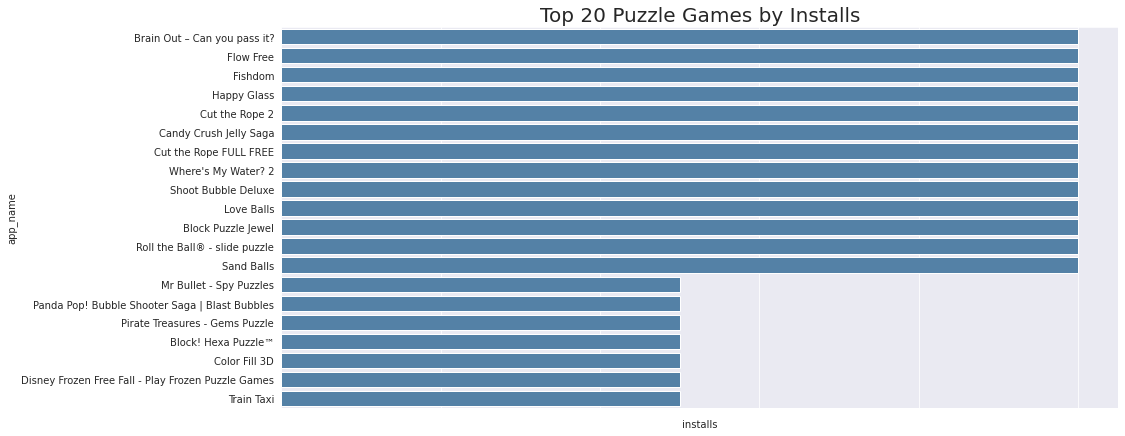

In [ ]:
sns.set_style("darkgrid")

# exclude the outliers as it distors the plot
g = sns.barplot(data=games_df[games_df.game_genre == "Puzzle"].sort_values(by='installs', ascending=False).head(20), 
                x="installs", 
                y="app_name",
                color='steelblue')

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.axes.set_title("Top 20 Puzzle Games by Installs",fontsize=20)
g.figure.set_size_inches(15,7)

Let's explore another approach to shortlist top 5 Puzzle games. 

We will pick the top 10 puzzle games with maximum reviews, and then sort them based on ratings.

In [120]:
games_df[games_df.game_genre == "Puzzle"].sort_values(by=['reviews', 'rating'], ascending=False).head(5)

developer                      app_name app_type  \
7943                          Playrix                       Fishdom     Free   
25488                            Peak                    Toon Blast     Free   
21664                      Focus apps  Brain Out – Can you pass it?     Free   
25483                            Peak                     Toy Blast     Free   
15123  FDG Entertainment GmbH & Co.KG                      Paperama     Free   

      game_genre installs_range     installs    reviews  rating  
7943      Puzzle          100M+  100000000.0  3752447.0     4.0  
25488     Puzzle           50M+   50000000.0  2759575.0     4.6  
21664     Puzzle          100M+  100000000.0  2738853.0     4.4  
25483     Puzzle           50M+   50000000.0  2644574.0     4.6  
15123     Puzzle           10M+   10000000.0  2506120.0     4.6

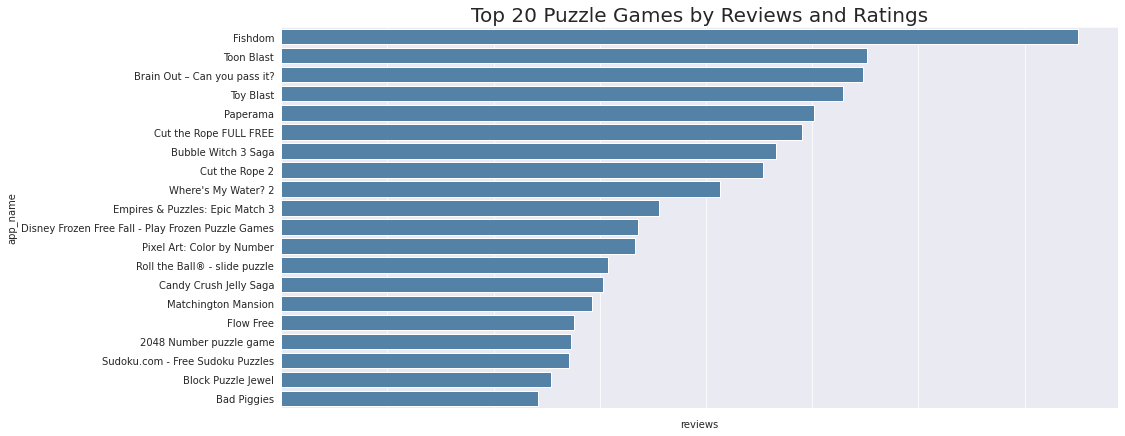

In [122]:
sns.set_style("darkgrid")

# exclude the outliers as it distors the plot
g = sns.barplot(data=games_df[games_df.game_genre == "Puzzle"].sort_values(by=['reviews', 'rating'], ascending=False).head(20), 
                x="reviews", 
                y="app_name",
                color='steelblue')

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.axes.set_title("Top 20 Puzzle Games by Reviews and Ratings",fontsize=20)
g.figure.set_size_inches(15,7)

#### Findings
Based on combination of the 2 lists, I will pick the folloing 3 which appears in both the lists 
1. Cut the Rope
2. Brain Out – Can you pass it?
3. Fishdom

Special Note - 
- Developing a Match-3 Puzzle game looks like a good option; most of the top puzzle games are match-3 - Fishdom, Toon Blast, Toy Blast, Bubble Witch 3 Saga, Empires & Puzzles

### Q&A 7 - I want to make a paid mobile app. What is the ideal price point to sell it for?

In [ ]:
app_df.app_type.value_counts()

Free    48334
Paid     5319
Name: app_type, dtype: int64

About 90% off the apps are Free to download. Here we will focus on the reminder 10% that are paid.

In [ ]:
pd.DataFrame(app_df[ "cost_usd"]).describe().T

count      mean       std  min  25%  50%  75%    max
cost_usd  53653.0  0.441148  4.028732  0.0  0.0  0.0  0.0  391.3

In [ ]:
app_df[app_df["cost_usd"]  > 0].groupby(["app_category"]).agg({'cost_usd': ['count', np.median, np.mean, np.std, np.max]}).reset_index()

app_category cost_usd                                   
                  count median      mean        std   amax
0          App     3169    2.5  4.837267  13.474950  391.3
1         Game     2150    3.0  3.878884   9.635577  391.3

For the paid Apps, median cost is 2.5 USD, whereas for Games it is slightly higer, 3 USD.
Maximum cost of paid apps for both Games and Apps are 392 USD.

In [ ]:
fig = px.histogram(app_df[app_df.cost_usd > 0], 
                x="cost_usd", 
                facet_col="app_category",
                nbins = 20,
                hover_data=['app_name'],
                labels={'cost_usd':'App Cost in USD'},
                title='App Coist in USD',
                marginal="box")

fig.update_layout(bargap=0.1)

fig.update_layout(title_font_size=20) 
fig.show()

Find the apps that costs $200 or more.

There are 5 such apps. Except 1, all have ~1000 install. 
Only one app - *Alarmy (Sleep If U Can) - Pro* in the lst has more than 10k installs and is well received by users. It has about 75% 5-star ratings.

In [ ]:
app_df[app_df.cost_usd >= 200].sort_values(by = "cost_usd", ascending = False)

app_id                       app_name app_category          genre  \
20225   21391     Plasma duct - Premium Game         Game         Puzzle   
42077   43548             JAVAD Mobile Tools          App          Tools   
36148   37234  Alarmy (Sleep If U Can) - Pro          App      Lifestyle   
23205   23486          Restaurant POS (Paid)          App       Business   
17725   18751              Roulette Syllabus          App  Entertainment   

           app_genre game_genre app_type  cost_usd  iap_usd  installs  ...  \
20225            NaN     Puzzle     Paid     391.3      0.9    1000.0  ...   
42077          Tools        NaN     Paid     391.3      NaN    1000.0  ...   
36148      Lifestyle        NaN     Paid     384.8      NaN   10000.0  ...   
23205       Business        NaN     Paid     256.5      NaN     500.0  ...   
17725  Entertainment        NaN     Paid     208.7      NaN     500.0  ...   

       reviews  rating  rate_5_pc  rate_4_pc  rate_3_pc  rate_2_pc  rate_1_pc  \
20225     84.0     3.5    54.0541    4.32432    7.02703   7.027030   27.56760   
42077    138.0     3.6    40.6504   22.76420    9.34959  10.975600   16.26020   
36148  11558.0     4.2    74.0741    8.14815    2.22222   2.222220   13.33330   
23205    114.0     4.4    71.4286   15.71430    7.85714   0.714286    4.28571   
17725     33.0     4.0    70.4225    2.81690    2.81690   5.633800   18.30990   

       content_rating  update_date           developer  
20225    Rated for 3+   2019-03-04           Synthesis  
42077    Rated for 3+   2020-02-05      JAVAD GNSS INC  
36148    Rated for 3+   2020-02-10  Alarm Clock Alarmy  
23205    Rated for 3+   2020-01-02               aadhk  
17725   Rated for 12+   2015-01-07   Roulette Syllabus  

[5 rows x 22 columns]

##### Findings
- Less than 10% mobile apps are paid; so you need to stand out of the free ones.
- For the paid Apps, median cost is 2.5 USD, whereas for Games it is slightly higer, 3 USD.

### Q&A 8: Which are the apps that most well received and loved by users? 
Let's define 'well received and loved by users' as - 
1. It has highest 5-Star rating percentage
2. It's reviewed by more than 50k users

In [ ]:
most_loved_df = app_df[['app_name', 'app_category', 'installs_range', 'reviews', 'rating', 'rate_5_pc', 'rate_4_pc', 'rate_3_pc', 'rate_2_pc', 'rate_1_pc']]
most_loved_df = most_loved_df[most_loved_df['reviews']>50000]
most_loved_df.sort_values(by=['rate_5_pc', 'rating', 'reviews'], ascending=False)

app_name app_category  \
29680  Sajda - Ramadan, Muslim Prayer times, Quran, A...          App   
17763       Vlinder Life : Dressup Avatar & Fashion Doll         Game   
9531     Fotogenic : Body & Face tune and Retouch Editor          App   
55                      Thomas & Friends: Magical Tracks         Game   
34653                        Билеты ПДД 2020+Экзамен ПДД          App   
...                                                  ...          ...   
12567                        Automatic Call Recorder Pro          App   
37800                            Chess With Friends Free         Game   
1287   Weather Underground: Local Weather Maps & Fore...          App   
25502                                         DeviantArt          App   
24953                                Yarn - Chat Fiction          App   

      installs_range   reviews  rating  rate_5_pc  rate_4_pc  rate_3_pc  \
29680            1M+   59333.0     4.9    98.0392   1.960780    0.00000   
17763          500K+   96178.0     4.9    97.0874   0.970874    0.00000   
9531             1M+  211876.0     4.8    97.0874   0.970874    0.00000   
55              10M+   55327.0     4.8    97.0874   0.970874    0.00000   
34653            1M+  135631.0     4.9    96.1538   3.846150    0.00000   
...              ...       ...     ...        ...        ...        ...   
12567          100K+   52032.0     2.5    28.9474   6.842110    5.26316   
37800            1M+   85433.0     2.9    26.6447  14.802600   13.48680   
1287             5M+  410178.0     2.6    24.7748   9.009010    7.20721   
25502            5M+   96058.0     2.5    23.8806   7.462690    8.95522   
24953           10M+   99484.0     1.8    15.3846   2.307690    2.30769   

       rate_2_pc  rate_1_pc  
29680    0.00000    0.00000  
17763    0.00000    1.94175  
9531     0.00000    1.94175  
55       0.00000    1.94175  
34653    0.00000    0.00000  
...          ...        ...  
12567    6.31579   52.63160  
37800   12.17110   32.89470  
1287    13.96400   45.04500  
25502    9.95025   49.75120  
24953    3.07692   76.92310  

[5541 rows x 10 columns]

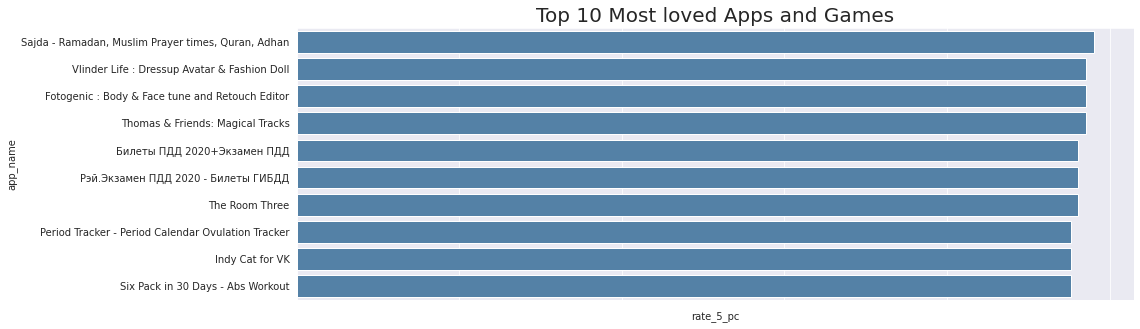

In [124]:
sns.set_style("darkgrid")

# exclude the outliers as it distors the plot
g = sns.barplot(data=most_loved_df.sort_values(by=['rate_5_pc', 'rating', 'reviews'], ascending=False).head(10), 
                x="rate_5_pc", 
                y="app_name",
                color='steelblue')

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.axes.set_title("Top 10 Most loved Apps and Games",fontsize=20)
g.figure.set_size_inches(15,5)

##### Findings
- 'Sajda - Ramadan, Muslim Prayer times, Quran, Adhan' is most user- appreciated app
- The next 2 are 'Vlinder Life : Dressup Avatar & Fashion Doll', a Game, and 'Fotogenic : Body & Face tune and Retouch Editor', an App.

### Q&A 9: What users say about WhatsApp and Facebook, the top 2 most popular apps from Meta Inc?

Meta has 12 apps live in GooglePlay store from Facebook as developer.

We will consider Facebook (App ID 2519) for user review analysis.

In [125]:
app_df[app_df['developer'] == 'Facebook'][['app_id', 'app_name', 'developer']].reset_index()

index  app_id                                  app_name developer
0     651     690  Messenger – Text and Video Chat for Free  Facebook
1     934     988                   Workplace from Facebook  Facebook
2     936     991                            Workplace Chat  Facebook
3    2391    2519                                  Facebook  Facebook
4    3231    3403     Messenger Lite: Free Calls & Messages  Facebook
5    3235    3407                      Facebook Ads Manager  Facebook
6    3239    3411                    Facebook Pages Manager  Facebook
7    4371    4607                            Facebook Local  Facebook
8   10226   10820                            Creator Studio  Facebook
9   21836    3402                             Facebook Lite  Facebook
10  21897    4606                        Facebook Analytics  Facebook
11  26556   27051                              Origami Live  Facebook

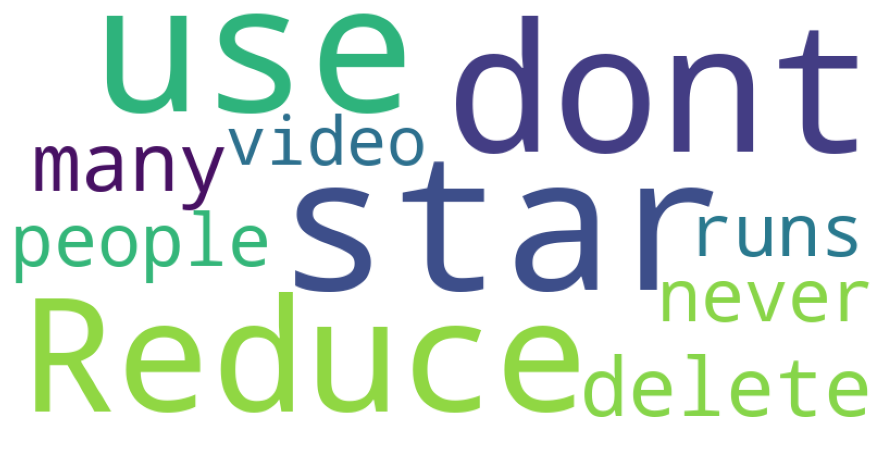

In [126]:
# create a single column dataframe by sorting the top-most helpful comments
comment_facebook_df = comment_df[comment_df['app_id'] == 2519]["content"]

# prepare the text to analyse
text_facebook = " ".join(cat.split()[1] for cat in comment_facebook_df)

# stopwords 
stop_words = list(STOPWORDS) + ["App", "app", "apps", "a", "i", "continues", "main", "isnt", "will", "happen", "clicking", "Facebook"]

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(stopwords = stop_words, collocation_threshold=int(1e6), width=800, height=400, background_color='white').generate(text_facebook)

plt.figure(figsize=(16,8))
plt.axis("off")
plt.grid(False)
plt.imshow(word_cloud);

#### Findings
- Most common words users review Facebook with are 'Star', 'Don't', "Delete", "Never". 
- It's not very insightful, and needs NLP-based approach to understand what users feel about Facebook.

Meta has published 3 apps live in GooglePlay store under the brand WhatsApp.

Here we ill consider WhatsApp Messenger (App id: 3318)

In [127]:
app_df[app_df['developer'] == 'WhatsApp Inc.'][['app_id', 'app_name', 'developer']].reset_index()

index  app_id            app_name      developer
0   3150    3318  WhatsApp Messenger  WhatsApp Inc.
1   9974   10553  WhatsApp Wallpaper  WhatsApp Inc.
2   9978   10557   WhatsApp Business  WhatsApp Inc.

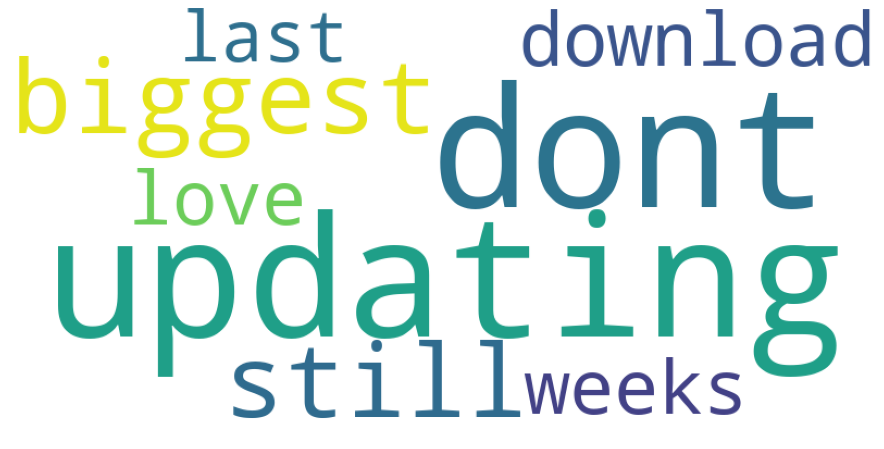

In [128]:
# create a single column dataframe by sorting the top-most helpful comments
comment_whatsapp_df = comment_df[comment_df['app_id'] == 3318]["content"]

# prepare the text to analyse
text_whatsapp = " ".join(cat.split()[1] for cat in comment_whatsapp_df)

# stopwords 
stop_words = list(STOPWORDS) + ["App", "app", "apps", "a", "i", "whatsapp"]

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(stopwords = stop_words, collocation_threshold=int(1e6), width=800, height=400, background_color='white').generate(text_whatsapp)

plt.figure(figsize=(16,8))
plt.axis("off")
plt.grid(False)
plt.imshow(word_cloud);

#### Findings
- 'Updating' is the most common word, so users are sensetive to the experience after updating the app, either in a positive or negative way.
- There is a word 'love' which shows some sizable userbase likes it.

### Q&A 9: What users say about Google, the most popular developer?

Google is the most popular developer in GooglePlay store. It has 24 apps that are live at the time of collecting this data. We will consider user reviews from all of them to study the user sentiment.

In [129]:
app_df[app_df['developer'] == 'Google LLC'][['app_id', 'app_name', 'developer']].reset_index()

index  app_id                                           app_name  \
0      90      96                                       YouTube Kids   
1     130     139                                        Google Lens   
2     134     143                                         Calculator   
3     138     147                                   Google Translate   
4     142     151                       Gboard - the Google Keyboard   
5     146     156         Google Go: A lighter, faster way to search   
6     425     448                                  Google Play Games   
7     627     664                          Maps - Navigate & Explore   
8     640     678                                             Google   
9     641     679                                Google Pinyin Input   
10    722     764                                      Google Photos   
11    772     817  Google Play Books - Ebooks, Audiobooks, and Co...   
12    885     936                                   Google Classroom   
13    898     950                                  Google Play Music   
14    911     963                                            YouTube   
15    912     964                                         YouTube Go   
16    930     984                                        Google Meet   
17   1309    1381                       Google Chrome: Fast & Secure   
18   1358    1433                                         Chrome Dev   
19   2386    2514                             Android System WebView   
20   3590    3786                                           Snapseed   
21   5376    5676                           Chrome Canary (Unstable)   
22  21706     946        YouTube Music - Stream Songs & Music Videos   
23  21733    1448                                        Chrome Beta   

     developer  
0   Google LLC  
1   Google LLC  
2   Google LLC  
3   Google LLC  
4   Google LLC  
5   Google LLC  
6   Google LLC  
7   Google LLC  
8   Google LLC  
9   Google LLC  
10  Google LLC  
11  Google LLC  
12  Google LLC  
13  Google LLC  
14  Google LLC  
15  Google LLC  
16  Google LLC  
17  Google LLC  
18  Google LLC  
19  Google LLC  
20  Google LLC  
21  Google LLC  
22  Google LLC  
23  Google LLC

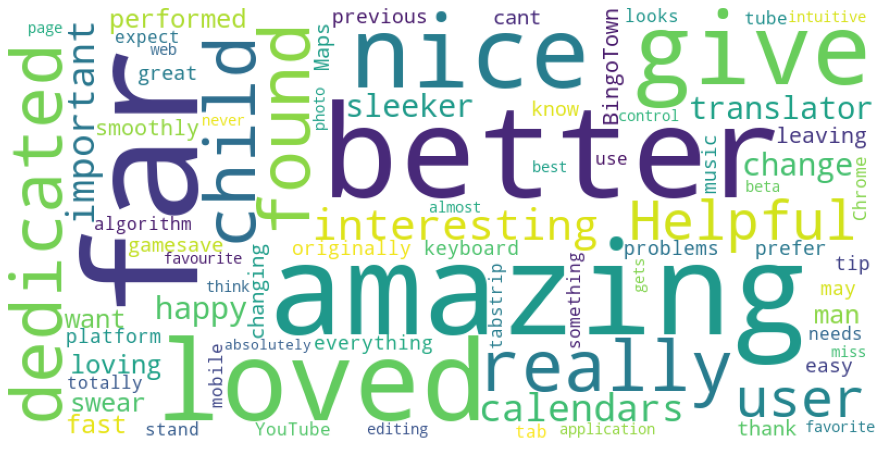

In [130]:
# create a filter for all the 5-star ratings for Google
filtered_values_google_5 = np.where((comment_df['developer'] == 'Google LLC') & (comment_df['stars'] == 5))

# create a single column dataframe by sorting the top-most helpful comments
comment_google_5_star_df = comment_df.loc[filtered_values_google_5]['content']

# prepare the text to analyse
text_google_5 = " ".join(cat.split()[1] for cat in comment_google_5_star_df)

# stopwords 
stop_words = list(STOPWORDS) + ["Google", "App", "app", "apps", "a", "i", "used", "new", "last", "keep", "version", "lens", "using", "love", "using", "good", "go"]

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(stopwords = stop_words, collocation_threshold=int(1e6), width=800, height=400, background_color='white').generate(text_google_5)

plt.figure(figsize=(16,8))
plt.axis("off")
plt.grid(False)
plt.imshow(word_cloud);

Some common words used in praise of Google are *love, nice, amazing, better, helpful.*

These doesn't perticularly give any insight. We may have to do NLP analysis to derive any actionable insight.

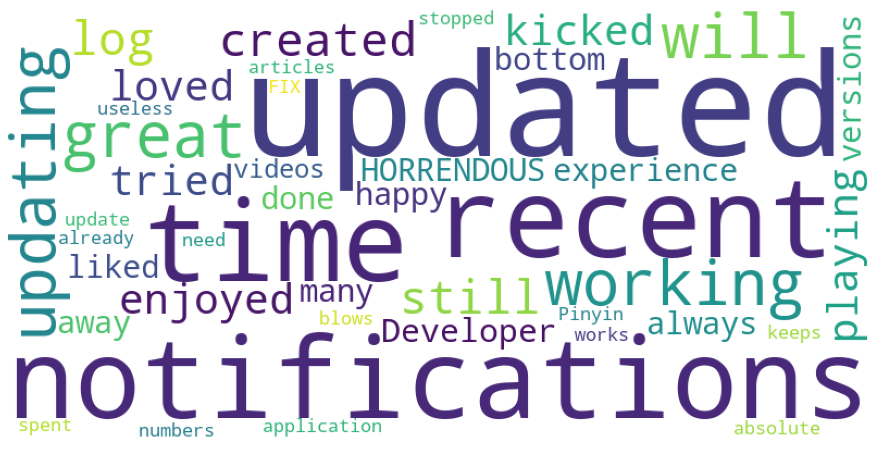

In [131]:
# create a filter for all the 1-star ratings for Google
filtered_values_google_1 = np.where((comment_df['developer'] == 'Google LLC') & (comment_df['stars'] == 1))

# create a single column dataframe by sorting the top-most helpful comments
comment_google_1_star_df = comment_df.loc[filtered_values_google_1].sort_values(by= "helpfuls", ascending=False)['content'].head(150)

# prepare the text to analyse
text_google_1 = " ".join(cat.split()[1] for cat in comment_google_1_star_df)

# stopwords 
stop_words = list(STOPWORDS) + ["Google", "App", "app", "apps", "a", "i", "used", "new", "last", "keep", "version", "lens", "using", "love", "using", "good", "go"]

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(stopwords = stop_words, collocation_threshold=int(1e6), width=800, height=400, background_color='white').generate(text_google_1)

plt.figure(figsize=(16,8))
plt.axis("off")
plt.grid(False)
plt.imshow(word_cloud);

#### Findings 
- The most frequent critical words are *updated, recent, notifications, horrendous, tried.*
- It's possible that users faced some issues followed by recetnly updating an app. Developer should keep a close eye on the user feedbacks after pushing an update. 
- Also, users may not like notifications. Google may educate users on how to turn off the notifications to avoid getting lower ratings by agitated users. 

### Q&A 11: Is there any coorelation between the most helpful comments and the star ratings by the users?

In [132]:
# aggregate
star_helpful_agg_df = comment_df.groupby(["stars", "app_category"]).agg({'helpfuls': ['count']}).reset_index()

# the table header is multiindex, so renaiming it
star_helpful_agg_df.columns = star_helpful_agg_df.columns.get_level_values(0)

star_helpful_agg_df

stars app_category  helpfuls
0   1.0          App    110241
1   1.0         Game     82127
2   2.0          App     34993
3   2.0         Game     34526
4   3.0          App     44449
5   3.0         Game     48492
6   4.0          App     68584
7   4.0         Game     68050
8   5.0          App    271411
9   5.0         Game    216247

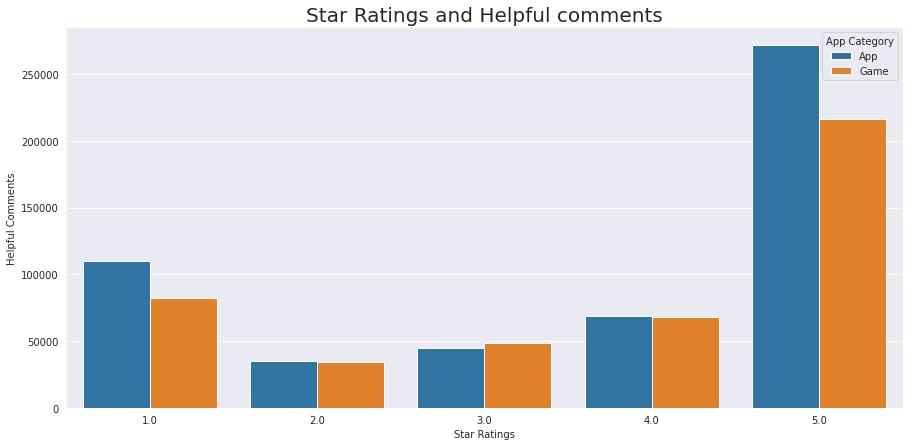

In [133]:
sns.set_style("darkgrid")
g = sns.barplot(data=star_helpful_agg_df, 
                x="stars", 
                y="helpfuls", 
                hue="app_category")

g.figure.set_size_inches(15,7)

plt.title('Star Ratings and Helpful comments', fontsize=20)
plt.legend(title='App Category')
plt.xlabel('Star Ratings');
plt.ylabel('Helpful Comments');

#### Findings
Users upvote 5-Star reviews and 1-Star reviews to make them most helpful. 2, 3 and 4-Star ratings are not voted by users as helpful could be as they may be neutral, or not talking about any specefic issue.

### Q&A 12: Most Reviewd Games and Apps Genre

In [145]:
# create a new aggregate dataframe for finding total reviews segmented by app category and genre
game_reviews_agg_df = pd.DataFrame(app_df[app_df["app_category"] == "Game"].groupby(["game_genre"])['reviews'].sum().astype('int64'))

# make the index as a new column for plotting
game_reviews_agg_df.reset_index(inplace=True)

game_reviews_agg_df.sort_values(by="reviews", ascending = False).head(5)

game_genre    reviews
0      Action  291085618
6      Casual  221781163
2      Arcade  175284115
13     Sports  134693211
10     Racing  130653448

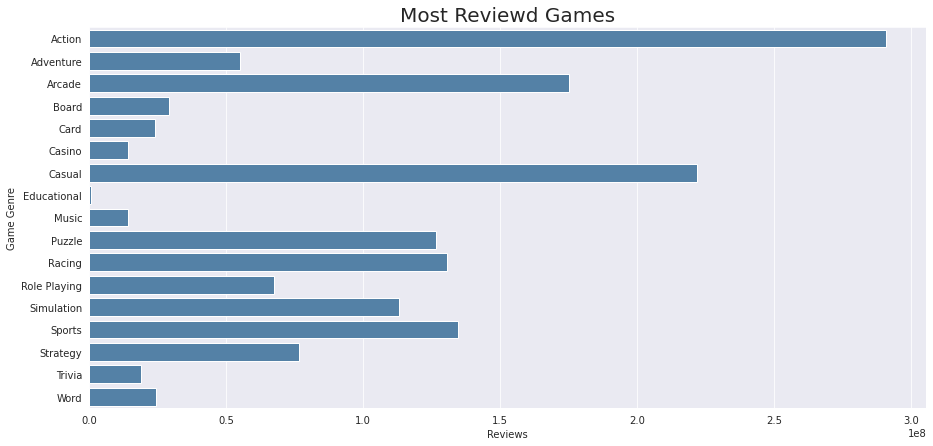

In [158]:
sns.set_style("darkgrid")
g = sns.barplot(data=game_reviews_agg_df, 
                x="reviews", 
                y="game_genre",
                color='steelblue') 

g.figure.set_size_inches(15,7)

plt.title('Most Reviewd Games', fontsize=20)
plt.xlabel('Reviews');
plt.ylabel('Game Genre');

##### Findings
- Action and Casual games are the most reviewd games by users.

In [162]:
# create a new aggregate dataframe for finding total reviews segmented by app category and genre
app_reviews_agg_df = pd.DataFrame(app_df[app_df["app_category"] == "App"].groupby(["app_genre"])['reviews'].sum().astype('int64'))

# make the index as a new column for plotting
app_reviews_agg_df.reset_index(inplace=True)

app_reviews_agg_df.sort_values(by="reviews", ascending = False).head(5)

app_genre    reviews
6             Communication  350763975
26                   Social  293251106
27                    Tools  182802288
29  Video Players & Editors  143896444
23              Photography  139495986

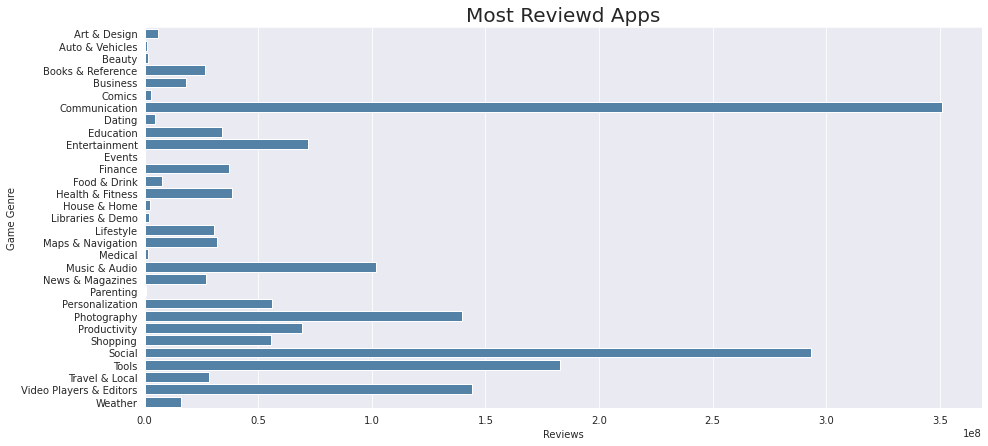

In [161]:
sns.set_style("darkgrid")
g = sns.barplot(data=app_reviews_agg_df, 
                x="reviews", 
                y="app_genre",
                color='steelblue') 

g.figure.set_size_inches(15,7)

plt.title('Most Reviewd Apps', fontsize=20)
plt.xlabel('Reviews');
plt.ylabel('Game Genre');

##### Findings
- Communication and Social are the most reviewd apps.

### Q&A 13: Is there any relation between Ratings and Installs?

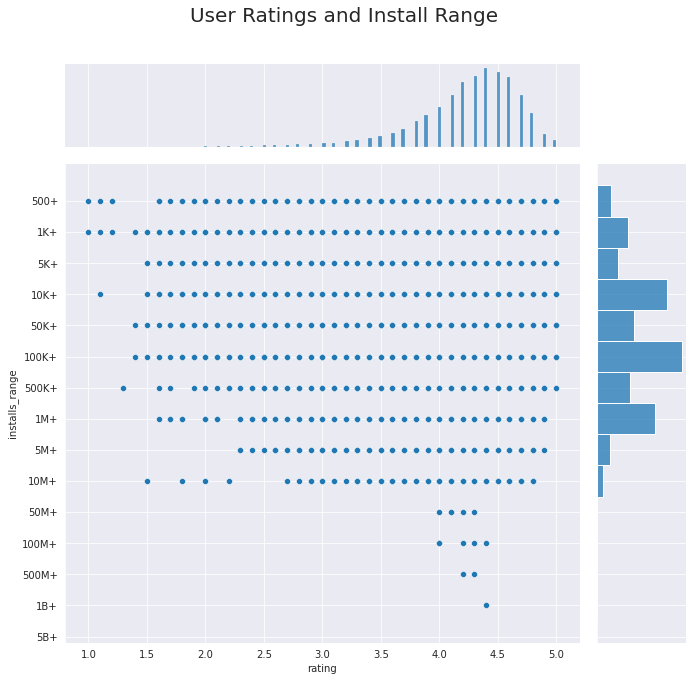

In [163]:
sns.set_style("darkgrid")

# exclude the outliers as it distors the plot
g = sns.jointplot(data=app_df[app_df.reviews < 100000], 
                x="rating", 
                y="installs_range",
                # order=["500+","1K+", "5K+", "10K+", "50K+", "100K+", "500K+",  "1M+",  "5M+", "10M+", "50M+", "100M+", "500M+", "1B+", "5B+"]
                )

g.figure.set_size_inches(10,10)
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle("User Ratings and Install Range", fontsize=20);

##### Findings
- Apps with 50m+ installs, understandably don't have ratings below 4. They are the most popular ones.

### Q&A 14: Is there any relation between Ratings and number of Reviews?

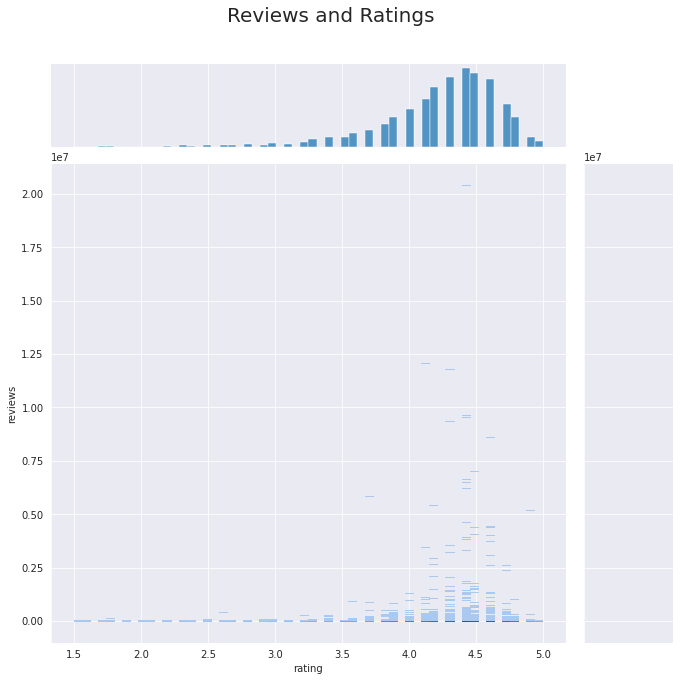

In [164]:
sns.set_style("darkgrid")

# exclude the outliers as it distors the plot
g = sns.jointplot(data=app_df[["rating", "reviews"]].sample(5000), 
                x="rating", 
                y="reviews", 
                kind="hist")
g.figure.set_size_inches(10,10)
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle("Reviews and Ratings", fontsize=20);

##### Findings
- As the computation was getting frozen, I have consdered a sample of 5000 records. But then no clear relation is seen. This needs further investigation. 

# Step 5: Summarize inferences & write a conclusion

1. Summary of what is learned from the analysis, interesting insights and graphs from previous sections
2. Ideas for future work on the same topic using other relevant datasets
3. Links to useful resources during your analysis

<img src="https://www.perceptive-analytics.com/wp-content/uploads/2019/10/24-768x512.png" 
alt="GooglePlay" 
style="width: 800px; margin-left: 50; margin-right: 50;"/>

## 1. Summary of what is learned from the analysis

More than 90% of mobile apps are Free in GooglePlay store.

In [165]:
fig = px.pie(app_df, 
            values=app_df.app_type.value_counts().values, 
            names=app_df.app_type.value_counts().index, 
            title='GooglePlay: Free and Paid apps',
            hole=.3)

fig.update_layout(title_font_size=20) 
fig.show()

#### Installs are heavily skewed
60% of the apps have less than 100k installs. 
Only 20% gets more than 1 million installs. 

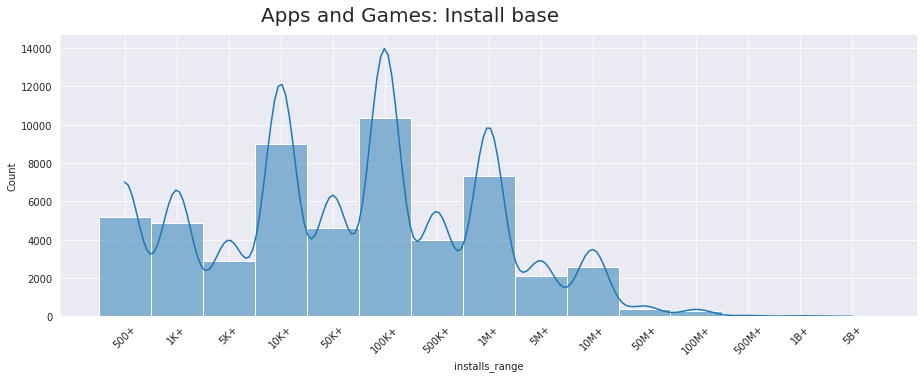

In [166]:
# install lbase distribuion
sns.set_style("darkgrid")
g = sns.displot(data=app_df, 
                x="installs_range", 
                kde=True)
g.set_xticklabels(rotation=45)
g.figure.set_size_inches(15,5)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle("Apps and Games: Install base", fontsize=20);

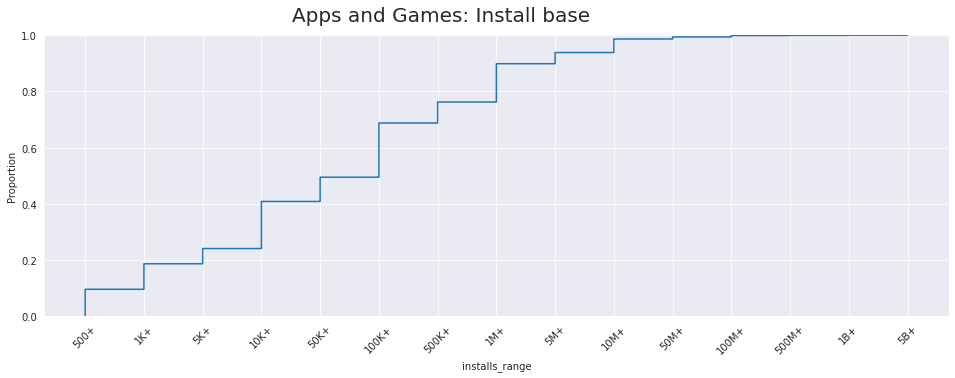

In [167]:
# install lbase distribuion
sns.set_style("darkgrid")
g = sns.displot(data=app_df, 
                x="installs_range", 
                kind="ecdf")

g.set_xticklabels(rotation=45)
g.figure.set_size_inches(15,5)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle("Apps and Games: Install base", fontsize=20);

#### Top Developers
By size of their userbase, 4 out of top 10 are Game developers. 

Most popular developers are Google, Samsung and Meta (Facebook, WhatsApp, Instagram)

King, Outfit7 and Miniclip are the most popular Game developer.



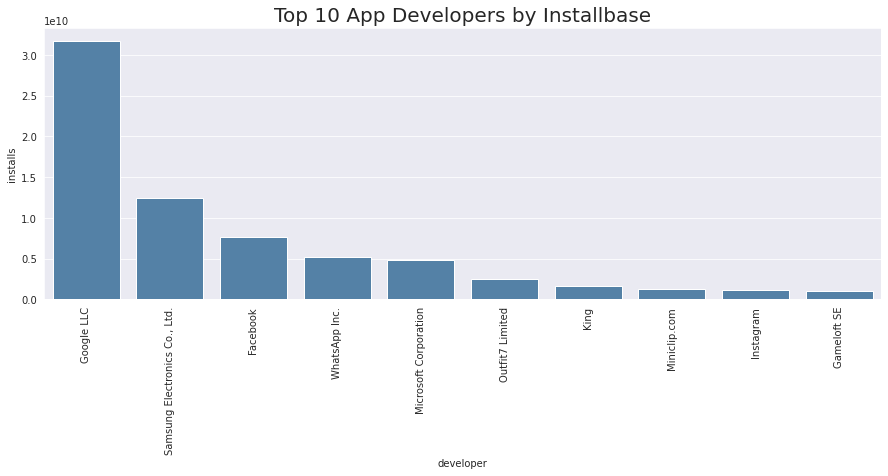

In [168]:
# Top 20 App Developers by installs 
top_devs_df = app_df.groupby('developer', as_index=False)[['installs']].sum().sort_values(by='installs', ascending=False).copy(deep=True)
top_devs_df['installs'] = top_devs_df['installs'].astype('int64')

# plot 
sns.set_style("darkgrid")

# exclude the outliers as it distors the plot
g = sns.barplot(data=top_devs_df.head(10), 
                x="developer", 
                y="installs",
                color='steelblue')

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.axes.set_title("Top 10 App Developers by Installbase",fontsize=20)
g.figure.set_size_inches(15,5)

## 2. Ideas for future work 

- The scraping was done in April 2020. We can run a web-scrapper to collect the latest data.
- User sentiment can be more insighful if advanced techniques like NLP is used.
- Spend more time in finding relation between ratings and reviews. 

## 3. Links to useful resources

Dataframe Lambda function and Dataframe Apply 
- https://www.appsloveworld.com/pandas/100/475/pandas-using-iloc-apply-and-lambda-with-df-column-as-part-of-condition
- https://realpython.com/fast-flexible-pandas/
- https://www.digitalocean.com/community/tutorials/pandas-dataframe-apply-examples 

Suppressing Scientific notation
- https://stackoverflow.com/questions/40347689/dataframe-describe-suppress-scientific-notation

Handling NaN
- https://stackoverflow.com/questions/16729483/converting-strings-to-floats-in-a-dataframe
- https://stackoverflow.com/questions/62782511/checking-for-np-nan-inside-function-that-is-applied-to-dataframe 

Where conditions in dataframe
- https://stackoverflow.com/questions/43757977/replacing-values-greater-than-a-number-in-pandas-dataframe

Conditional subsetting data in dataframe
- https://stackoverflow.com/questions/43632927/pandas-select-rows-from-dataframe-based-on-condition
- https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html

Sorting categorical columns in Pandas DataFrame 
- https://www.skytowner.com/explore/sorting_categorical_columns_in_pandas_dataframe
- https://soulsinporto.medium.com/custom-sort-a-pandas-dataframe-with-pd-categorical-c4eec8343957 

Manipulating Dataframes
- https://sparkbyexamples.com/pandas/pandas-create-new-dataframe-by-selecting-specific-columns
- https://stackoverflow.com/questions/20965046/cumulative-sum-and-percentage-on-column

Handling zeros in pandas DataFrames column divisions
- https://stackoverflow.com/questions/16244180/handling-zeros-in-pandas-dataframes-column-divisions-in-python

Pandas PivotTable
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html
- https://www.analyticsvidhya.com/blog/2020/03/pivot-table-pandas-python/

Plotting
- Plotly Express: https://plotly.com/python/plotly-express/
- Seaborn: https://seaborn.pydata.org/tutorial/introduction
- Plotyly Sunbrust Chart: https://www.youtube.com/watch?v=9jiynC5Vjto 
- Adding title to FacetGrid: https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot

Debugging 
- SettingwithCopyWarning: https://www.analyticsvidhya.com/blog/2021/11/3-ways-to-deal-with-settingwithcopywarning-in-pandas/
- SettingwithCopyWarning: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

General Readings
- GooglePlay definition: https://www.techtarget.com/searchmobilecomputing/definition/Google-Play-Android-Market
- GooglePlay and AppStore fugures: https://www.businessofapps.com/guide/app-stores-list/
- Android userbase: https://www.statista.com/topics/876/android/#topicHeader__wrapper
- App Volumne: https://appinventiv.com/blog/google-play-store-statistics/